# In this Jupyter notebook we will show the image processing pipeline used to quantify adhesion.

In [4]:
#importing the packages used
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import scipy.stats as stats
import pandas as pd
from skimage.morphology import square
from skimage.measure import label, regionprops
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from skimage.filters import threshold_otsu
import skimage.io
import skimage.filters
import skimage.measure
import seaborn as sns
import os

root = "/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/"

#Show the actual image from an image matrix
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')

#To read an image:
def read_image(filename):
    image = plt.imread(filename)

#set directory
base_dir = os.path.normpath(root + "internal data/google drive data/scanner/")

#Make crop function
def crop(image):
    image=np.delete(image,range(950,1017),0)
    image=np.delete(image,range(0,75),0)
    image=np.delete(image,range(1400,1432),1)
    image=np.delete(image,range(0,90),1)
    return image

#Define each colony as a distinct "object"
def connected_components(filename, connectivity=2):
    # load the image
    image = skimage.io.imread(filename)
    #Crop the image
    image=crop(image)
    #blur the image
    image = skimage.filters.gaussian(image, sigma=7, truncate=8, channel_axis=True)
    # make an inverted binary
    thresh = threshold_otsu(image)
    binary = image > thresh
    binary_mask=np.invert(binary)
    #Set the minimum area of an object to 2 pixels (python was picking up 1-pixel objects when I first tried it)

    #mask is the binary mask from which objects were found (a matrix of 1s and 0s)
    mask = skimage.morphology.remove_small_objects(binary_mask,1000)
    # perform connected component analysis (count=number of objects)

    #count is the number of objects there are (numbered 1-96 if there are 96 objects)
    #labeled_image is a matrix where each object is numbered 1-96 (the background is 0)
    labeled_image, count = skimage.measure.label(mask,connectivity=connectivity, return_num=True)

    #regions group the individual object properties
    regions=regionprops(labeled_image)
    return labeled_image, count, regions, mask




#Find and label objects in the original JB50 7x7 plate

baseline_fname = root + "internal data/google drive data/scanner/20220627_biofilm_JB50_7x7/20220627_1_biofilm_JB50_7x7.jpg"
labeled_image,count,regions,mask=connected_components(baseline_fname)

#Name each object after its position (A1-H12)
def number_plate(regions):
  x_array=[]
  y_array=[]
  for r in regions:
    x,y=r["centroid"]
    x_array.append(x)
    y_array.append(y)
  rows=pd.cut(x_array,8, labels=["A","B","C","D","E","F","G","H"])
  cols=pd.cut(y_array,12, labels=["1","2","3","4","5","6","7","8","9","10","11","12"])
  index=[]
  for i in range(0,len(rows)):
    index.append(rows[i]+cols[i])
  d = {'x': x_array, 'y': y_array, "row": rows, "col":cols, "index": index}
  df = pd.DataFrame(data=d)
  return df

#Show the dataframe of x (vertical) and y (horizontal) coordinates of the centroid of each object
df=number_plate(regions)

m=np.zeros((len(mask),len(mask[0])))

for ind in df["index"]:
  i=df[df['index']==ind].index[0]
  r=df[df["row"]==df.iat[i,2]]
  c=df[df["col"]==df.iat[i,3]]
  x=st.mean([df.iat[r[r["col"]=="12"].index[0],0],df.iat[r[r["col"]=="1"].index[0],0]])
  y=st.mean([df.iat[c[c["row"]=="A"].index[0],1],df.iat[c[c["row"]=="H"].index[0],1]])
  minr=int(round(x-45))
  minc=int(round(y-45))
  maxr=int(round(x+45))
  maxc=int(round(y+45))
  m[minr:maxr,minc:maxc]=square(90)

#Find and label objects in the new binary
labeled_image, count = skimage.measure.label(m,connectivity=2, return_num=True)
regions=regionprops(labeled_image)

#Return a dataframe of x and y coordinates of object centroids
df=number_plate(regions)

#Make a dictionary of each plate number
plate={}
n=0
for r in range(0,len(regions)):
  n=df.iat[r,2]+df.iat[r,3]
  plate[n]=regions[r]

#Create an array of mean intensity for each square for "image" from "labeled_image"
def mean_int(image,labeled_image,plate):
    mi=[]
    for i in dict.keys(plate):
        m=np.mean(image[np.where(labeled_image==plate[i]["label"])])
        mi.append(m)
    maxval=np.max(image)
    return mi, maxval 

#Make a dataframe with all info for each strain and only keep segregants and B2 (759) and C2 (JB50)
def processing(image,image_w,rep,map_names,plate,strain_layout,labeled_image_,keep_all=False):
    mean_intensities,max_val = mean_int(image, labeled_image_,plate)
    mean_intensities_w, max_val_w = mean_int(image_w, labeled_image_,plate)
    
    before_vals = mean_intensities/max_val
    before_vals = before_vals - np.min(before_vals)

    after_vals = mean_intensities_w/max_val_w
    #after_vals- np.min(after_vals or if less than 0, then 0
    after_vals = np.maximum(after_vals - np.min(after_vals),0)

    d = {"rep":rep,
        'position': dict.keys(plate),
         "x_coord":[plate[i]["centroid"][1] for i in dict.keys(plate)],
         "y_coord":[plate[i]["centroid"][0] for i in dict.keys(plate)],
         "strain":strain_layout,
         'before_wash': before_vals,
         "after_wash": after_vals
        }
    df = pd.DataFrame(data=d)
    df["ratio"]=df["after_wash"]/df["before_wash"]
    #remove entries where position starts with A or H,
    if keep_all==False:
      df=df[~df["position"].str.contains("A|H")]
      #for position, put a _ after the letter and the number like "B_1_"
      df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
      #add a _ to the end of position entries
      df["position"]=df["position"]+"_"
      #remove entries where position has format letter + 1_end, letter + 12
      df=df[~df["position"].str.contains("_1_|_12_")]
    else:
      df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
      df["position"]=df["position"]+"_"

    #df_seg=df.loc[df['strain'].isin(map_names)]
    #df_seg=pd.concat([df.loc[df['position'] == "B2"],df.loc[df['position'] == "C2"],df_seg])
    return df

#Import images
def import_im(directory):
  image_1=np.invert(crop(skimage.io.imread(directory)))
  return image_1

# Import strain layouts

In [6]:
#Get the layout of the strains, make a vector of strain names in order (by row so A1, A2, etc.)

map_filename = pd.read_excel(root + "internal data/Old wild strain map.xlsx", header = None)
#strains=pd.read_csv(map_filename,header=None)
strains=pd.DataFrame.transpose(map_filename)
strain_layout=[]
for i in range(0,8): #get strains in each of 8 columns
    strain_layout.extend(strains[i])
    
#Create an array of segregant names
map_names=['R' + str(ind) for ind in list(range(1,97))]


map_filename = pd.read_excel(root + "internal data/final wild strain map.xlsx", header = None)
#strains=pd.read_csv(map_filename,header=None)
strains=pd.DataFrame.transpose(map_filename)
strain_layout2=[]
for i in range(0,8): #get strains in each of 8 columns
    strain_layout2.extend(strains[i])

map_filename = pd.read_csv(root + "internal data/segregant_strains_map.csv", header = None)
#strains=pd.read_csv(map_filename,header=None)
strains=pd.DataFrame.transpose(map_filename)
strain_layout3=[]
for i in range(0,8): #get strains in each of 8 columns
    strain_layout3.extend(strains[i])

#repeat for /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/strains_mimi_cris.xlsx
map_filename = pd.read_excel(root + "internal data/strains_mimi_cris.xlsx", header = None)
#strains=pd.read_csv(map_filename,header=None)
strains=pd.DataFrame.transpose(map_filename)
strain_layout4=[]
for i in range(0,8): #get strains in each of 12 columns
    strain_layout4.extend(strains[i])

    


In [7]:
labeled_im_2=np.zeros((len(labeled_image),len(labeled_image[0])))
labeled_im_2[:-20,:-80]=labeled_image[20:,80:]

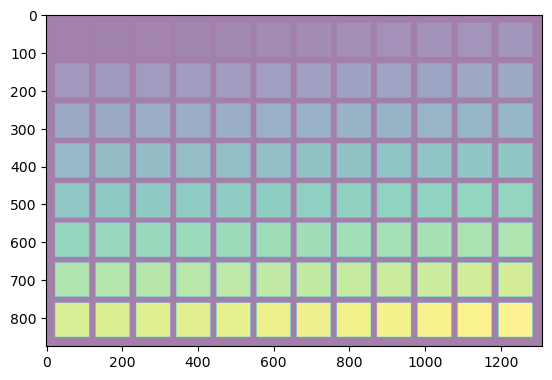

In [8]:

#overlay labeled image on original image
#plt.imshow(segregants_3)
#remove the 20 pixels of the left side
labeled_im_=labeled_image[:,30:]
plt.imshow(labeled_image,alpha=0.5)


In [9]:

labeled_im_3=np.zeros((len(labeled_image),len(labeled_image[0])))
labeled_im_3[:-30,:-20]=labeled_image[30:,20:]

labeled_im_4=np.zeros((len(labeled_image),len(labeled_image[0])))
#Move it down and slighlty right
labeled_im_4[:-10,:-20]=labeled_image[10:,20:]

labeled_im_5=np.zeros((len(labeled_image),len(labeled_image[0])))
#Move it down and slighlty right
labeled_im_5[:-15,:-50]=labeled_image[15:,50:]

labeled_im_6=np.zeros((len(labeled_image),len(labeled_image[0])))
#Move it down and slighlty right
labeled_im_6[:-30,:]=labeled_image[30:,:]


# import images

In [11]:

#Isolates data from Celeste and our early measurements on EMM


isolates_1 = import_im(root + "internal data/google drive data/scanner/20220729_biofilm_WT_lib/20220729_1_biofilm_WT_lib.jpg")
isolates_1_w=import_im(root + "internal data/google drive data/scanner/20220729_biofilm_WT_lib_w/20220729_1_biofilm_WT_lib_w.jpg")
isolates_2 = import_im(root + "internal data/google drive data/scanner/20221010_biofilm_isolates_lib2/20221010_1_biofilm_isolates_lib2.jpg")
isolates_2_w=import_im(root + "internal data/google drive data/scanner/20221010_biofilm_isolates_lib2_w/20221010_1_biofilm_isolates_lib2_w.jpg")
isolates_3 = import_im(root + "internal data/google drive data/scanner//20221021_biofilm_isolates_lib_oct20__1/20221021_1_biofilm_isolates_lib_oct20__1.jpg")
isolates_3_w=import_im(root + "internal data/google drive data/scanner//20221021_biofilm_isolates_lib_oct20__1___w/20221021_1_biofilm_isolates_lib_oct20__1___w.jpg")
isolates_4 = import_im(root + "internal data/google drive data/scanner/20221021_biofilm_isolates_lib_oct20__2/20221021_1_biofilm_isolates_lib_oct20__2.jpg")
isolates_4_w=import_im(root + "internal data/google drive data/scanner/20221021_biofilm_isolates_lib_oct20__2___w/20221021_1_biofilm_isolates_lib_oct20__2___w.jpg")
isolates_5 = import_im(root + "internal data/google drive data/scanner/20221021_biofilm_isolates_lib_oct20__3/20221021_1_biofilm_isolates_lib_oct20__3.jpg")
isolates_5_w=import_im(root + "internal data/google drive data/scanner/20221021_biofilm_isolates_lib_oct20__3___w/20221021_1_biofilm_isolates_lib_oct20__3___w.jpg")
isolates_6 = import_im(root + "internal data/google drive data/scanner/20221021_biofilm_isolates_lib_oct20__4/20221021_1_biofilm_isolates_lib_oct20__4.jpg")
isolates_6_w=import_im(root + "internal data/google drive data/scanner/20221021_biofilm_isolates_lib_oct20__4___w/20221021_1_biofilm_isolates_lib_oct20__4___w.jpg")

#More EMM from nov 25.
isolates_7 = import_im(root + "internal data/data from usb/20221125_biofilm_wi_1_emm/20221125_1_biofilm_wi_1.jpg")
isolates_7_w=import_im(root + "internal data/data from usb/20221125_biofilm_wi_1_emm_w/20221125_1_biofilm_wi_1_emm_w.jpg")
isolates_8 = import_im(root + "internal data/data from usb/20221125_biofilm_wi_2_emm/20221125_1_biofilm_wi_2_emm.jpg")
isolates_8_w=import_im(root + "internal data/data from usb/20221125_biofilm_wi_2_emm_w/20221125_1_biofilm_wi_2_emm_w.jpg")
isolates_9 = import_im(root + "internal data/data from usb/20221125_biofilm_wi_3_emm/20221125_1_biofilm_wi_3_emm.jpg")
isolates_9_w=import_im(root + "internal data/data from usb/20221125_biofilm_wi_3_emm_w/20221125_1_biofilm_wi_3_emm_w.jpg")
isolates_10 = import_im(root + "internal data/data from usb/20221125_biofilm_wi_4_emm/20221125_1_biofilm_wi_4_emm.jpg")
isolates_10_w=import_im(root + "internal data/data from usb/20221125_biofilm_wi_4_emm_w/20221125_1_biofilm_wi_4_emm_w.jpg")
isolates_11 = import_im(root + "internal data/data from usb/20221125_biofilm_wi_5_emm/20221125_1_biofilm_wi_5_emm.jpg")
isolates_11_w=import_im(root + "internal data/data from usb/20221125_biofilm_wi_5_emm_w/20221125_1_biofilm_wi_5_emm_w.jpg")


#Isolates data on YES from Nov 25.
isolates_yes_1 = import_im(root + "internal data/data from usb/20221125_biofilm_wi_1_yes/20221125_1_biofilm_wi_1_yes.jpg")
isolates_yes_1_w=import_im(root + "internal data/data from usb/20221125_biofilm_wi_1_yes_w/20221125_1_biofilm_wi_1_yes_w.jpg")
isolates_yes_2 = import_im(root + "internal data/data from usb/20221125_biofilm_wi_2_yes/20221125_1_biofilm_wi_2_yes.jpg")
isolates_yes_2_w=import_im(root + "internal data/data from usb/20221125_biofilm_wi_2_yes_w/20221125_1_biofilm_wi_2_yes_w.jpg")
isolates_yes_3 = import_im(root + "internal data/data from usb/20221125_biofilm_wi_3_yes/20221125_1_biofilm_wi_3_yes.jpg")
isolates_yes_3_w=import_im(root + "internal data/data from usb/20221125_biofilm_wi_3_yes_w/20221125_1_biofilm_wi_3_yes_w.jpg")
isolates_yes_4 = import_im(root + "internal data/data from usb/20221125_biofilm_wi_4_yes/20221125_1_biofilm_wi_4_yes.jpg")
isolates_yes_4_w=import_im(root + "internal data/data from usb/20221125_biofilm_wi_4_yes_w/20221125_1_biofilm_wi_4_yes_w.jpg")
isolates_yes_5 = import_im(root + "internal data/data from usb/20221125_biofilm_wi_5_yes/20221125_1_biofilm_wi_5_yes.jpg")
isolates_yes_5_w=import_im(root + "internal data/data from usb/20221125_biofilm_wi_5_yes_w/20221125_1_biofilm_wi_5_yes_w.jpg")
isolates_yes_6 = import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_ctrl_123_/20230313_1_biofilm_wi_ctrl_123_.jpg")
isolates_yes_6_w = import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_ctrl_123_w/20230313_1_biofilm_wi_ctrl_123_w.jpg")
isolates_yes_7 = import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_ctrl_123_/20230313_2_biofilm_wi_ctrl_123_.jpg")
isolates_yes_7_w=import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_ctrl_123_w/20230313_2_biofilm_wi_ctrl_123_w.jpg")
isolates_yes_8 = import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_ctrl_123_/20230313_3_biofilm_wi_ctrl_123_.jpg")
isolates_yes_8_w=import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_ctrl_123_w/20230313_3_biofilm_wi_ctrl_123_w.jpg")




# isolates /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb/20221205_biofilm_wi_cris_1_emm/20221205_1_biofilm_wi_cris_1_emm.jpg
isolates_cris_1 = import_im(root + "internal data/data from usb/20221205_biofilm_wi_cris_1_emm/20221205_1_biofilm_wi_cris_1_emm.jpg")
isolates_cris_1_w=import_im(root + "internal data/data from usb/20221205_biofilm_wi_cris_1_emm_w/20221205_1_biofilm_wi_cris_1_emm_w.jpg")
isolates_cris_2 = import_im(root + "internal data/data from usb/20221205_biofilm_wi_cris_2_emm/20221205_1_biofilm_wi_cris_2_emm.jpg")
isolates_cris_2_w=import_im(root + "internal data/data from usb/20221205_biofilm_wi_cris_2_emm_w/20221205_1_biofilm_wi_cris_2_emm_w.jpg")

#same for mimi
isolates_mimi_1 = import_im(root + "internal data/data from usb/20221205_biofilm_wi_mimi_3_emm/20221205_1_biofilm_wi_mimi_3_emm.jpg")
isolates_mimi_1_w=import_im(root + "internal data/data from usb/20221205_biofilm_wi_mimi_3_emm_w/20221205_1_biofilm_wi_mimi_3_emm_w.jpg")
isolates_mimi_2 = import_im(root + "internal data/data from usb/20221205_biofilm_wi_mimi_44_emm/20221205_1_biofilm_wi_mimi_44_emm.jpg")
isolates_mimi_2_w=import_im(root + "internal data/data from usb/20221205_biofilm_wi_mimi_4_emm_w/20221205_1_biofilm_wi_mimi_4_emm_w.jpg")

df_cris = processing(isolates_cris_1, isolates_cris_1_w, 1,map_names,plate,strain_layout4,labeled_im_,keep_all=True)
df_cris2 = processing(isolates_cris_2, isolates_cris_2_w, 2,map_names,plate,strain_layout4,labeled_im_,keep_all=True)
df_mimi = processing(isolates_mimi_1, isolates_mimi_1_w, 1,map_names,plate,strain_layout4,labeled_im_,keep_all=True)
df_mimi2 = processing(isolates_mimi_2, isolates_mimi_2_w, 2,map_names,plate,strain_layout4,labeled_im_,keep_all=True)

df1=processing(isolates_1, isolates_1_w, 1,map_names,plate,strain_layout,labeled_image)
df2=processing(isolates_2, isolates_2_w, 2,map_names,plate,strain_layout2,labeled_im_)
df3=processing(isolates_3, isolates_3_w, 3,map_names,plate,strain_layout2,labeled_im_)
df4=processing(isolates_4, isolates_4_w, 4,map_names,plate,strain_layout2,labeled_im_)
df5=processing(isolates_5, isolates_5_w, 5,map_names,plate,strain_layout2,labeled_im_)
df6=processing(isolates_6, isolates_6_w, 6,map_names,plate,strain_layout2,labeled_im_)
df7=processing(isolates_7, isolates_7_w, 7,map_names,plate,strain_layout2,labeled_im_)
df8=processing(isolates_8, isolates_8_w, 8,map_names,plate,strain_layout2,labeled_im_)
df9=processing(isolates_9, isolates_9_w, 9,map_names,plate,strain_layout2,labeled_im_)
df10=processing(isolates_10, isolates_10_w, 10,map_names,plate,strain_layout2,labeled_im_)
df11=processing(isolates_11, isolates_11_w, 11,map_names,plate,strain_layout2,labeled_im_)

df_1_yes = processing(isolates_yes_1, isolates_yes_1_w, 1,map_names,plate,strain_layout2,labeled_im_)
df_2_yes = processing(isolates_yes_2, isolates_yes_2_w, 2,map_names,plate,strain_layout2,labeled_im_)
df_3_yes = processing(isolates_yes_3, isolates_yes_3_w, 3,map_names,plate,strain_layout2,labeled_im_)
df_4_yes = processing(isolates_yes_4, isolates_yes_4_w, 4,map_names,plate,strain_layout2,labeled_im_)
df_5_yes = processing(isolates_yes_5, isolates_yes_5_w, 5,map_names,plate,strain_layout2,labeled_im_)
df_6_yes = processing(isolates_yes_6, isolates_yes_6_w, 6,map_names,plate,strain_layout2,labeled_im_)
df_7_yes = processing(isolates_yes_7, isolates_yes_7_w, 7,map_names,plate,strain_layout2,labeled_im_2)
df_8_yes = processing(isolates_yes_8, isolates_yes_8_w, 8,map_names,plate,strain_layout2,labeled_im_4)


segregants_1  = import_im(root + "Bence folder/Phenotypes/biofilm_washing_scans/20220704_biofilm_lib1/20220704_1_biofilm_lib1.jpg")
segregants_1_w = import_im(root + "Bence folder/Phenotypes/biofilm_washing_scans/20220704_biofilm_lib1_w/20220704_1_biofilm_lib1_w.jpg")
segregants_2  = import_im(root + "Bence folder/Phenotypes/biofilm_washing_scans/20220704_biofilm_lib2/20220704_1_biofilm_lib2.jpg")
segregants_2_w = import_im(root + "Bence folder/Phenotypes/biofilm_washing_scans/20220704_biofilm_lib2_w/20220704_1_biofilm_lib2_w.jpg")
segregants_3  = import_im(root + "Bence folder/Phenotypes/biofilm_washing_scans/20220704_biofilm_lib3/20220704_1_biofilm_lib3.jpg")
segregants_3_w = import_im(root + "Bence folder/Phenotypes/biofilm_washing_scans/20220704_biofilm_lib3_w/20220704_1_biofilm_lib3_w.jpg")
segregants_4  = import_im(root + "Bence folder/Phenotypes/biofilm_washing_scans/20220704_biofilm_lib4/20220704_1_biofilm_lib4.jpg")
segregants_4_w = import_im(root + "Bence folder/Phenotypes/biofilm_washing_scans/20220704_biofilm_lib4_w/20220704_1_biofilm_lib4_w.jpg")


segregants_5 = import_im(root + "internal data/data from usb/20221108_biofilm_seg_lib_nov9--1/20221108_1_biofilm_seg_lib_nov9--1.jpg")
segregants_5_w = import_im(root + "internal data/data from usb/20221108_biofilm_seg_lib_nov9--1w/20221108_1_biofilm_seg_lib_nov9--1w.jpg")
segregants_6 = import_im(root + "internal data/data from usb/20221108_biofilm_seg_lib_nov9--2/20221108_1_biofilm_seg_lib_nov9--2.jpg")
segregants_6_w = import_im(root + "internal data/data from usb/20221108_biofilm_seg_lib_nov9--2w/20221108_1_biofilm_seg_lib_nov9--2w.jpg")
segregants_7 = import_im(root + "internal data/data from usb/20221108_biofilm_seg_lib_nov9--3/20221108_1_biofilm_seg_lib_nov9--3.jpg")
segregants_7_w = import_im(root + "internal data/data from usb/20221108_biofilm_seg_lib_nov9--3w/20221108_1_biofilm_seg_lib_nov9--3w.jpg")
segregants_8 = import_im(root + "internal data/data from usb/20221108_biofilm_seg_lib_nov9--4/20221108_1_biofilm_seg_lib_nov9--4.jpg")
segregants_8_w = import_im(root + "internal data/data from usb/20221108_biofilm_seg_lib_nov9--4w/20221108_1_biofilm_seg_lib_nov9--4w.jpg")
segregants_9 = import_im(root + "internal data/data from usb/20221108_biofilm_seg_lib_nov9--5/20221108_1_biofilm_seg_lib_nov9--5.jpg")
segregants_9_w = import_im(root + "internal data/data from usb/20221108_biofilm_seg_lib_nov9--5w/20221108_1_biofilm_seg_lib_nov9--5w.jpg")
segregants_10 = import_im(root + "internal data/data from usb/20221107_biofilm_seg_lib_nov7-1/20221107_1_biofilm_seg_lib_nov7-1.jpg")
segregants_10_w = import_im(root + "internal data/data from usb/20221107_biofilm_seg_lib_nov7-1w/20221107_1_biofilm_seg_lib_nov7-1w.jpg")
segregants_11 = import_im(root + "internal data/data from usb/20221107_biofilm_seg_lib_nov7-2/20221107_1_biofilm_seg_lib_nov7-2.jpg")
segregants_11_w = import_im(root + "internal data/data from usb/20221107_biofilm_seg_lib_nov7-2w/20221107_1_biofilm_seg_lib_nov7-2w.jpg")
segregants_12 = import_im(root + "internal data/data from usb/20221107_biofilm_seg_lib_nov7-3/20221107_1_biofilm_seg_lib_nov7-3.jpg")
segregants_12_w = import_im(root + "internal data/data from usb/20221107_biofilm_seg_lib_nov7-3w/20221107_1_biofilm_seg_lib_nov7-3w.jpg")
segregants_13 = import_im(root + "internal data/data from usb/20221107_biofilm_seg_lib_nov7-4/20221107_1_biofilm_seg_lib_nov7-4.jpg")
segregants_13_w = import_im(root + "internal data/data from usb/20221107_biofilm_seg_lib_nov7-4w/20221107_1_biofilm_seg_lib_nov7-4w.jpg")
segregants_14 = import_im(root + "internal data/data from usb/20221107_biofilm_seg_lib_nov7-5/20221107_1_biofilm_seg_lib_nov7-5.jpg")
segregants_14_w = import_im(root + "internal data/data from usb/20221107_biofilm_seg_lib_nov7-5w/20221107_1_biofilm_seg_lib_nov7-5w.jpg")

#segregant YES /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb/20221125_biofilm_seg_1_yes/20221125_1_biofilm_seg_1_yes.jpg
segregants_yes_1 = import_im(root + "internal data/data from usb/20221125_biofilm_seg_1_yes/20221125_1_biofilm_seg_1_yes.jpg")
segregants_yes_1_w = import_im(root + "internal data/data from usb/20221125_biofilm_seg_1_yes_w/20221125_1_biofilm_seg_1_yes_w.jpg")
segregants_yes_2 = import_im(root + "internal data/data from usb/20221125_biofilm_seg_2_yes/20221125_1_biofilm_seg_2_yes.jpg")
segregants_yes_2_w = import_im(root + "internal data/data from usb/20221125_biofilm_seg_2_yes_w/20221125_1_biofilm_seg_2_yes_w.jpg")



df_s_1=processing(segregants_1, segregants_1_w, 1,map_names,plate,strain_layout3, labeled_image)
df_s_2=processing(segregants_2, segregants_2_w, 2,map_names,plate,strain_layout3, labeled_image)
df_s_3=processing(segregants_3, segregants_3_w, 3,map_names,plate,strain_layout3, labeled_image)
df_s_4=processing(segregants_4, segregants_4_w, 4,map_names,plate,strain_layout3, labeled_image)
df_s_5=processing(segregants_5, segregants_5_w, 5,map_names,plate,strain_layout3, labeled_im_)
df_s_6=processing(segregants_6, segregants_6_w, 6,map_names,plate,strain_layout3, labeled_im_)
df_s_7=processing(segregants_7, segregants_7_w, 7,map_names,plate,strain_layout3, labeled_im_)
df_s_8=processing(segregants_8, segregants_8_w, 8,map_names,plate,strain_layout3, labeled_im_)
df_s_9=processing(segregants_9, segregants_9_w, 9,map_names,plate,strain_layout3, labeled_im_)
df_s_10=processing(segregants_10, segregants_10_w, 10,map_names,plate,strain_layout3, labeled_im_)
df_s_11=processing(segregants_11, segregants_11_w, 11,map_names,plate,strain_layout3, labeled_im_)
df_s_12=processing(segregants_12, segregants_12_w, 12,map_names,plate,strain_layout3, labeled_im_)
df_s_13=processing(segregants_13, segregants_13_w, 13,map_names,plate,strain_layout3, labeled_im_)
df_s_14=processing(segregants_14, segregants_14_w, 14,map_names,plate,strain_layout3, labeled_im_)

df_s_yes_1=processing(segregants_yes_1, segregants_yes_1_w, 1,map_names,plate,strain_layout3, labeled_im_)
df_s_yes_2=processing(segregants_yes_2, segregants_yes_2_w, 2,map_names,plate,strain_layout3, labeled_im_)





#Wild isolates on Caffeine
isolates_caf_1=import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_c_1234_/20230313_1_biofilm_wi_c_1234_1.jpg")
isolates_caf_1_w=import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_c_1234_w/20230313_1_biofilm_wi_c_1234_1_w.jpg")
isolates_caf_2=import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_c_1234_/20230313_2_biofilm_wi_c_1234_2.jpg")
isolates_caf_2_w=import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_c_1234_w/20230313_2_biofilm_wi_c_1234_2_w.jpg")
isolates_caf_3=import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_c_1234_/20230313_3_biofilm_wi_c_1234_3.jpg")
isolates_caf_3_w=import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_c_1234_w/20230313_3_biofilm_wi_c_1234_3_w.jpg")
isolates_caf_4=import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_c_1234_/20230313_4_biofilm_wi_c_1234_4.jpg")
isolates_caf_4_w=import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_c_1234_w/20230313_4_biofilm_wi_c_1234_4_w.jpg")
isolates_caf_5=import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_caf/20230411_1_biofilm_yes_wi_caf_1.jpg")
isolates_caf_5_w=import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_caf_w/20230411_1_biofilm_yes_wi_caf_1_w.jpg")
isolates_caf_6=import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_caf/20230411_2_biofilm_yes_wi_caf_2.jpg")
isolates_caf_6_w=import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_caf_w/20230411_2_biofilm_yes_wi_caf_2_w.jpg")
isolates_caf_7=import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_caf/20230411_3_biofilm_yes_wi_caf_3.jpg")
isolates_caf_7_w=import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_caf_w/20230411_3_biofilm_yes_wi_caf_3_w.jpg")

df_caf_1=processing(isolates_caf_1, isolates_caf_1_w, 1,map_names,plate,strain_layout2, labeled_im_)
df_caf_2=processing(isolates_caf_2, isolates_caf_2_w, 2,map_names,plate,strain_layout2, labeled_im_2)
df_caf_3=processing(isolates_caf_3, isolates_caf_3_w, 3,map_names,plate,strain_layout2, labeled_im_4)
df_caf_4=processing(isolates_caf_4, isolates_caf_4_w, 4,map_names,plate,strain_layout2, labeled_im_3)  
df_caf_5=processing(isolates_caf_5, isolates_caf_5_w, 5,map_names,plate,strain_layout2, labeled_im_)
df_caf_6=processing(isolates_caf_6, isolates_caf_6_w, 6,map_names,plate,strain_layout2, labeled_im_2)
df_caf_7=processing(isolates_caf_7, isolates_caf_7_w, 7,map_names,plate,strain_layout2, labeled_im_4)

#Wild isolates on Caffeine and Rap
isolates_caf_rap_1 = import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_cr_123_/20230313_1_biofilm_wi_cr_123_.jpg")
isolates_caf_rap_1_w = import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_cr_123_w/20230313_1_biofilm_wi_cr_123_w.jpg")
isolates_caf_rap_2 = import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_cr_123_/20230313_2_biofilm_wi_cr_123_.jpg")
isolates_caf_rap_2_w = import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_cr_123_w/20230313_2_biofilm_wi_cr_123_w.jpg")
isolates_caf_rap_3 = import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_cr_123_/20230313_3_biofilm_wi_cr_123_.jpg")
isolates_caf_rap_3_w = import_im(root + "internal data/data from usb march 20/20230313_biofilm_wi_cr_123_w/20230313_3_biofilm_wi_cr_123_w.jpg")
isolates_caf_rap_4 = import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_rc/20230411_1_biofilm_yes_wi_rc.jpg")
isolates_caf_rap_4_w = import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_rc_w/20230411_1_biofilm_yes_wi_rc_w.jpg")
isolates_caf_rap_5 = import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_rc/20230411_2_biofilm_yes_wi_rc.jpg")
isolates_caf_rap_5_w = import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_rc_w/20230411_2_biofilm_yes_wi_rc_w.jpg")

df_caf_rap_1=processing(isolates_caf_rap_1, isolates_caf_rap_1_w, 1,map_names,plate,strain_layout2, labeled_im_)
df_caf_rap_2=processing(isolates_caf_rap_2, isolates_caf_rap_2_w, 2,map_names,plate,strain_layout2, labeled_im_2)
df_caf_rap_3=processing(isolates_caf_rap_3, isolates_caf_rap_3_w, 3,map_names,plate,strain_layout2, labeled_im_4)
df_caf_rap_4=processing(isolates_caf_rap_4, isolates_caf_rap_4_w, 4,map_names,plate,strain_layout2, labeled_im_)
df_caf_rap_5=processing(isolates_caf_rap_5, isolates_caf_rap_5_w, 5,map_names,plate,strain_layout2, labeled_im_2)

#Wild isolates on Rapamycin
isolates_rap_1= import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_rap/20230411_1_biofilm_yes_wi_rap.jpg")
isolates_rap_1_w= import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_rap_w/20230411_1_biofilm_yes_wi_rap_w.jpg")
isolates_rap_2= import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_rap/20230411_2_biofilm_yes_wi_rap.jpg")
isolates_rap_2_w= import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_rap_w/20230411_2_biofilm_yes_wi_rap_w.jpg")

df_rap_1 = processing(isolates_rap_1, isolates_rap_1_w, 1,map_names,plate,strain_layout2, labeled_im_)
df_rap_2 = processing(isolates_rap_2, isolates_rap_2_w, 2,map_names,plate,strain_layout2, labeled_im_2)

#Wild isolates on EMM hydrogen peroxide
isolates_emm_h2o2_1= import_im(root + "internal data/data from usb apr 5/20230327_biofilm_wi_emm_h2o2_12/20230327_1_biofilm_wi_emm_h2o2_12.jpg")
isolates_emm_h2o2_1_w= import_im(root + "internal data/data from usb apr 5/20230327_biofilm_wi_emm_h2o2_12_w/20230327_1_biofilm_wi_emm_h2o2_12_w.jpg")
isolates_emm_h2o2_2=import_im(root + "internal data/data from usb apr 5/20230327_biofilm_wi_emm_h2o2_12/20230327_2_biofilm_wi_emm_h2o2_12.jpg")
isolates_emm_h2o2_2_w=import_im(root + "internal data/data from usb apr 5/20230327_biofilm_wi_emm_h2o2_12_w/20230327_2_biofilm_wi_emm_h2o2_12_w.jpg")

df_emm_h2o2_1 = processing(isolates_emm_h2o2_1, isolates_emm_h2o2_1_w, 1,map_names,plate,strain_layout2, labeled_im_4)
df_emm_h2o2_2 = processing(isolates_emm_h2o2_2, isolates_emm_h2o2_2_w, 2,map_names,plate,strain_layout2, labeled_im_2)

#Wild isolates on YES hydrogen peroxide
isolates_yes_h2o2_1=import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_h2o2/20230411_1_biofilm_yes_wi_h2o2.jpg")
isolates_yes_h2o2_1_w=import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_h2o2_w/20230411_1_biofilm_yes_wi_h2o2_w.jpg")
isolates_yes_h2o2_2= import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_h2o2/20230411_2_biofilm_yes_wi_h2o2.jpg")
isolates_yes_h2o2_2_w= import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_h2o2_w/20230411_2_biofilm_yes_wi_h2o2_w.jpg")
isolates_yes_h2o2_3= import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_h2o2/20230411_3_biofilm_yes_wi_h2o2.jpg")
isolates_yes_h2o2_3_w= import_im(root + "internal data/data from usb apr 11/20230411_biofilm_yes_wi_h2o2_w/20230411_3_biofilm_yes_wi_h2o2_w.jpg")

df_yes_h2o2_1 = processing(isolates_yes_h2o2_1, isolates_yes_h2o2_1_w, 1,map_names,plate,strain_layout2, labeled_im_4)
df_yes_h2o2_2 = processing(isolates_yes_h2o2_2, isolates_yes_h2o2_2_w, 2,map_names,plate,strain_layout2, labeled_im_2)
df_yes_h2o2_3 = processing(isolates_yes_h2o2_3, isolates_yes_h2o2_3_w, 3,map_names,plate,strain_layout2, labeled_im_4)




#Wild isolates on Nitrogen starvation EMM
isolate_emm_nitrogen_1 = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_n_1234___/20230416_1_biofilm_verylow_n_1234___.jpg")
isolate_emm_nitrogen_1_w = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_n_1234___w/20230416_1_biofilm_verylow_n_1234___w.jpg")
isolate_emm_nitrogen_2 = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_n_1234___/20230416_2_biofilm_verylow_n_1234___.jpg")
isolate_emm_nitrogen_2_w = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_n_1234___w/20230416_2_biofilm_verylow_n_1234___w.jpg")
isolate_emm_nitrogen_3 = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_n_1234___/20230416_3_biofilm_verylow_n_1234___.jpg")
isolate_emm_nitrogen_3_w = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_n_1234___w/20230416_3_biofilm_verylow_n_1234___w.jpg")

#Wild isolates on phosphate starvation emm
isolate_emm_phosphate_1 = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_p_1234/20230416_1_biofilm_verylow_p_1234.jpg")
isolate_emm_phosphate_1_w = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_p_1234_w/20230416_1_biofilm_verylow_p_1234_w.jpg")
isolate_emm_phosphate_2 = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_p_1234/20230416_2_biofilm_verylow_p_1234.jpg")
isolate_emm_phosphate_2_w = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_p_1234_w/20230416_2_biofilm_verylow_p_1234_w.jpg")
isolate_emm_phosphate_3 = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_p_1234/20230416_3_biofilm_verylow_p_1234.jpg")
isolate_emm_phosphate_3_w = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_p_1234_w/20230416_3_biofilm_verylow_p_1234_w.jpg")
isolate_emm_phosphate_4 = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_p_1234/20230416_4_biofilm_verylow_p_1234.jpg")
isolate_emm_phosphate_4_w = import_im(root + "internal data/apr 16/20230416_biofilm_verylow_p_1234_w/20230416_4_biofilm_verylow_p_1234_w.jpg")


df_emm_n_1 = processing(isolate_emm_nitrogen_1, isolate_emm_nitrogen_1_w, 1,map_names,plate,strain_layout2, labeled_image)
df_emm_n_2 = processing(isolate_emm_nitrogen_2, isolate_emm_nitrogen_2_w, 2,map_names,plate,strain_layout2, labeled_im_5)
df_emm_n_3 = processing(isolate_emm_nitrogen_3, isolate_emm_nitrogen_3_w, 3,map_names,plate,strain_layout2, labeled_image)

df_emm_p_1 = processing(isolate_emm_phosphate_1, isolate_emm_phosphate_1_w, 1,map_names,plate,strain_layout2, labeled_image)
df_emm_p_2 = processing(isolate_emm_phosphate_2, isolate_emm_phosphate_2_w, 2,map_names,plate,strain_layout2, labeled_im_5)
df_emm_p_3 = processing(isolate_emm_phosphate_3, isolate_emm_phosphate_3_w, 3,map_names,plate,strain_layout2, labeled_image)
df_emm_p_4 = processing(isolate_emm_phosphate_4, isolate_emm_phosphate_4_w, 4,map_names,plate,strain_layout2, labeled_im_6)

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/3800717978.py:165: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/3800717978.py:165: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/3800717978.py:165: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/3800717978.py:165: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var

# Assembling dataframes

### Wild isolates on EMM

In [12]:
DF=pd.concat([df1, df2, df3, df4, df5, df6,df7,df8,df9,df10,df11])
#if any of the ratios are higher than 1, just set them to 1
DF.loc[DF['ratio'] > 1, 'ratio'] = 1
#remove entries with before_wash less than 0.1
DF=DF[DF["before_wash"]>0.1]
DF_grouped=DF.groupby("strain",as_index=False).mean()

phenotype=DF_grouped[["strain","ratio","before_wash"]]
#as a column also add the sem of ratio
#remove ones with before_wash less than 30
phenotype=phenotype[phenotype["before_wash"]>0.1]

phenotype["sem"]=DF.groupby("strain",as_index=False).sem()["ratio"]


#also remove the entry where strain is TYPO
phenotype=phenotype[phenotype["strain"]!="TYPO"]
len(phenotype)

59

### Wild isolates on YES

In [13]:
DF_yes = pd.concat([df_1_yes, df_2_yes, df_3_yes, df_4_yes, df_5_yes,df_6_yes,df_7_yes, df_8_yes])
DF_yes.loc[DF_yes['ratio'] > 1, 'ratio'] = 1
#remove entries with before_wash less than 0.1
DF_yes=DF_yes[DF_yes["before_wash"]>0.1]
DF_yes_grouped=DF_yes.groupby("strain",as_index=False).mean()
phenotype_yes=DF_yes_grouped[["strain","ratio","before_wash"]]
phenotype_yes["sem"]=DF_yes.groupby("strain",as_index=False).sem()["ratio"]
#remove ones with before_wash less than 0.1
phenotype_yes=phenotype_yes[phenotype_yes["before_wash"]>0.1]
#also remove the entry where strain is TYPO
phenotype_yes=phenotype_yes[phenotype_yes["strain"]!="TYPO"]


len(phenotype_yes)

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/3028947220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_yes["sem"]=DF_yes.groupby("strain",as_index=False).sem()["ratio"]


59

### Wild isolates from Cris and Mimi on EMM


In [14]:
DF_mimi = pd.concat([df_mimi, df_mimi2])
DF_mimi.loc[DF_mimi['ratio'] > 1, 'ratio'] = 1
DF_mimi_grouped=DF_mimi.groupby("strain",as_index=False).mean()
phenotype_mimi=DF_mimi_grouped[["strain","ratio","before_wash"]]
phenotype_mimi["sem"]=DF_mimi.groupby("strain",as_index=False).sem()["ratio"]
phenotype_mimi=phenotype_mimi[phenotype_mimi["before_wash"]>0.1]
len(phenotype_mimi)

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/455781855.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_mimi["sem"]=DF_mimi.groupby("strain",as_index=False).sem()["ratio"]


56

In [15]:
DF_cris = pd.concat([df_cris, df_cris2])
DF_cris.loc[DF_cris['ratio'] > 1, 'ratio'] = 1
DF_cris_grouped=DF_cris.groupby("strain",as_index=False).mean()
phenotype_cris=DF_cris_grouped[["strain","ratio","before_wash"]]
phenotype_cris["sem"]=DF_cris.groupby("strain",as_index=False).sem()["ratio"]
phenotype_cris=phenotype_cris[phenotype_cris["before_wash"]>0.1]
len(phenotype_cris)


/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/2943327158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_cris["sem"]=DF_cris.groupby("strain",as_index=False).sem()["ratio"]


57

## Wild isolates on Caf

In [16]:
DF_caf=pd.concat([df_caf_1, df_caf_2, df_caf_3, df_caf_4, df_caf_5, df_caf_6, df_caf_7])
#if any of the ratios are higher than 1, just set them to 1
DF_caf.loc[DF_caf['ratio'] > 1, 'ratio'] = 1
DF_grouped=DF_caf.groupby("strain",as_index=False).mean()
#remove entries with before_wash less than 0.1
DF_caf=DF_caf[DF_caf["before_wash"]>0.1]
phenotype_caf=DF_grouped[["strain","ratio","before_wash"]]
#as a column also add the sem of ratio

phenotype_caf["sem"]=DF_caf.groupby("strain",as_index=False).sem()["ratio"]
#remove ones with before_wash less than 0.1
phenotype_caf=phenotype_caf[phenotype_caf["before_wash"]>0.1]

#also remove the entry where strain is TYPO
phenotype_caf=phenotype_caf[phenotype_caf["strain"]!="TYPO"]
phenotype_caf

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/1795806959.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_caf["sem"]=DF_caf.groupby("strain",as_index=False).sem()["ratio"]


,strain,ratio,before_wash,sem
1,JB1110,0.091174,0.188898,0.044434
2,JB1117,0.947426,0.248847,0.067287
3,JB1154,0.137773,0.371204,0.013709
4,JB1171,0.186598,0.379924,0.101229
5,JB1174,0.171409,0.436545,0.061800
6,JB1180,0.281035,0.292974,0.013935
7,JB1197,0.077572,0.168049,0.034404
8,JB1205,0.115998,0.150353,0.018729
9,JB1206,0.071599,0.211221,0.015888
10,JB1207,0.052157,0.357025,0.009103


Text(0.5, 0, 'Strain')

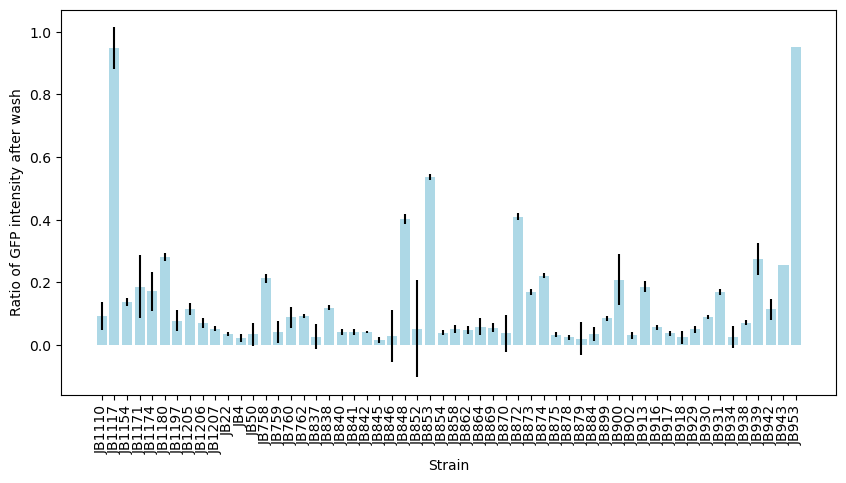

In [19]:
# phenotype_caf barplot with sem
plt.figure(figsize=(10,5))
plt.bar(phenotype_caf["strain"],phenotype_caf["ratio"],yerr=phenotype_caf["sem"],color="lightblue")
plt.xticks(rotation=90)
plt.ylabel("Ratio of GFP intensity after wash")
plt.xlabel("Strain")

# Wild isolates on Rap 

In [20]:
DF_rap=pd.concat([df_rap_1, df_rap_2])
#if any of the ratios are higher than 1, just set them to 1
DF_rap.loc[DF_rap['ratio'] > 1, 'ratio'] = 1
#remove entries with before_wash less than 0.1
DF_rap=DF_rap[DF_rap["before_wash"]>0.1]
DF_grouped=DF_rap.groupby("strain",as_index=False).mean()

phenotype_rap=DF_grouped[["strain","ratio","before_wash"]]
#as a column also add the sem of ratio

phenotype_rap["sem"]=DF_rap.groupby("strain",as_index=False).sem()["ratio"]
#remove ones with before_wash less than 0.1
phenotype_rap=phenotype_rap[phenotype_rap["before_wash"]>0.1]

#also remove the entry where strain is TYPO
phenotype_rap=phenotype_rap[phenotype_rap["strain"]!="TYPO"]
phenotype_rap


/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/844353809.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_rap["sem"]=DF_rap.groupby("strain",as_index=False).sem()["ratio"]


,strain,ratio,before_wash,sem
0,JB1110,0.064294,0.275432,0.039447
1,JB1117,0.130656,0.197483,0.060398
2,JB1154,0.045443,0.324622,0.019878
3,JB1171,0.037305,0.405855,0.023138
4,JB1174,0.037519,0.409960,0.019815
5,JB1180,0.077255,0.396270,0.028687
6,JB1197,0.076930,0.308214,0.037004
7,JB1205,0.083794,0.371873,0.022200
8,JB1206,0.051063,0.451769,0.017278
9,JB1207,0.034330,0.420524,0.019790


# Wild isolates on caffeine and rapamycin




In [21]:
DF_caf_rap=pd.concat([df_caf_rap_1, df_caf_rap_2, df_caf_rap_3, df_caf_rap_4, df_caf_rap_5])
#if any of the ratios are higher than 1, just set them to 1
DF_caf_rap.loc[DF_caf_rap['ratio'] > 1, 'ratio'] = 1
#remove entries with before_wash less than 0.1
DF_caf_rap=DF_caf_rap[DF_caf_rap["before_wash"]>0.1]
DF_grouped=DF_caf_rap.groupby("strain",as_index=False).mean()

phenotype_caf_rap=DF_grouped[["strain","ratio","before_wash"]]
#as a column also add the sem of ratio

phenotype_caf_rap["sem"]=DF_caf_rap.groupby("strain",as_index=False).sem()["ratio"]
#remove ones with before_wash less than 0.1
phenotype_caf_rap=phenotype_caf_rap[phenotype_caf_rap["before_wash"]>0.1]

#also remove the entry where strain is TYPO
phenotype_caf_rap=phenotype_caf_rap[phenotype_caf_rap["strain"]!="TYPO"]
phenotype_caf_rap

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/2857916985.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_caf_rap["sem"]=DF_caf_rap.groupby("strain",as_index=False).sem()["ratio"]


,strain,ratio,before_wash,sem
0,JB1117,0.677403,0.181925,0.159879
1,JB1154,0.042610,0.403765,0.010672
2,JB1171,0.055594,0.443407,0.009189
3,JB1174,0.054369,0.463325,0.009746
4,JB1180,0.061736,0.234560,0.012678
5,JB1205,0.089373,0.163116,0.014396
6,JB1206,0.063608,0.207476,0.015407
7,JB1207,0.053711,0.315270,0.013814
8,JB22,0.030848,0.419721,0.010380
9,JB4,0.051861,0.303226,0.010696


# Wild isolates EMM hydrogen peroxide


In [22]:
DF_h2o2_emm = pd.concat([df_emm_h2o2_1,df_emm_h2o2_2])
DF_h2o2_emm.loc[DF_h2o2_emm['ratio'] > 1, 'ratio'] = 1
#remove entries with before_wash less than 0.1
DF_h2o2_emm=DF_h2o2_emm[DF_h2o2_emm["before_wash"]>0.1]
DF_grouped=DF_h2o2_emm.groupby("strain",as_index=False).mean()

phenotype_h2o2_emm=DF_grouped[["strain","ratio","before_wash"]]
#as a column also add the sem of ratio

phenotype_h2o2_emm["sem"]=DF_h2o2_emm.groupby("strain",as_index=False).sem()["ratio"]
#remove ones with before_wash less than 0.1
phenotype_h2o2_emm=phenotype_h2o2_emm[phenotype_h2o2_emm["before_wash"]>0.1]

#also remove the entry where strain is TYPO
phenotype_h2o2_emm=phenotype_h2o2_emm[phenotype_h2o2_emm["strain"]!="TYPO"]
phenotype_h2o2_emm

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/2901331835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_h2o2_emm["sem"]=DF_h2o2_emm.groupby("strain",as_index=False).sem()["ratio"]


,strain,ratio,before_wash,sem
0,JB1117,0.890588,0.290296,0.041864
1,JB1154,0.154283,0.204695,0.053709
2,JB1171,0.051474,0.421158,0.028205
3,JB1174,0.047254,0.419031,0.024577
4,JB1206,0.046238,0.161984,0.043822
5,JB22,0.184178,0.189295,0.050801
6,JB4,0.104187,0.377391,0.050709
7,JB50,0.098513,0.284493,0.055241
8,JB758,0.052807,0.210418,0.026841
9,JB759,0.552834,0.184184,0.038139


# Wild isolates YES hydrogen peroxide


In [23]:
DF_h2o2_yes = pd.concat([df_yes_h2o2_1,df_yes_h2o2_2])
DF_h2o2_yes.loc[DF_h2o2_yes['ratio'] > 1, 'ratio'] = 1
#remove entries with before_wash less than 0.1
DF_h2o2_yes=DF_h2o2_yes[DF_h2o2_yes["before_wash"]>0.1]
DF_grouped=DF_h2o2_yes.groupby("strain",as_index=False).mean()

phenotype_h2o2_yes=DF_grouped[["strain","ratio","before_wash"]]
#as a column also add the sem of ratio


phenotype_h2o2_yes["sem"]=DF_h2o2_yes.groupby("strain",as_index=False).sem()["ratio"]
#remove ones with before_wash less than 0.1
phenotype_h2o2_yes=phenotype_h2o2_yes[phenotype_h2o2_yes["before_wash"]>0.1]

#also remove the entry where strain is TYPO
phenotype_h2o2_yes=phenotype_h2o2_yes[phenotype_h2o2_yes["strain"]!="TYPO"]
phenotype_h2o2_yes

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/1713052014.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_h2o2_yes["sem"]=DF_h2o2_yes.groupby("strain",as_index=False).sem()["ratio"]


,strain,ratio,before_wash,sem
0,JB1110,0.029199,0.429152,0.004899
1,JB1117,0.131424,0.221348,0.019064
2,JB1154,0.032029,0.472205,0.005705
3,JB1171,0.032356,0.483052,0.006180
4,JB1174,0.032496,0.482801,0.004670
5,JB1180,0.029538,0.459053,0.004784
6,JB1197,0.017842,0.413213,0.005741
7,JB1205,0.157141,0.466752,0.025612
8,JB1206,0.018573,0.470535,0.002090
9,JB1207,0.046729,0.493492,0.017094


# Wild Isolates YES EDTA


In [24]:
DF_edta_yes = pd.concat([df_yes_edta_1,df_yes_edta_2,df_yes_edta_3])
DF_edta_yes.loc[DF_edta_yes['ratio'] > 1, 'ratio'] = 1
#remove entries with before_wash less than 0.1
DF_edta_yes=DF_edta_yes[DF_edta_yes["before_wash"]>0.1]
DF_grouped=DF_edta_yes.groupby("strain",as_index=False).mean()

phenotype_edta_yes=DF_grouped[["strain","ratio","before_wash"]]
#as a column also add the sem of ratio

phenotype_edta_yes["sem"]=DF_edta_yes.groupby("strain",as_index=False).sem()["ratio"]
#remove ones with before_wash less than 0.1
phenotype_edta_yes=phenotype_edta_yes[phenotype_edta_yes["before_wash"]>0.1]

#also remove the entry where strain is TYPO
phenotype_edta_yes=phenotype_edta_yes[phenotype_edta_yes["strain"]!="TYPO"]
phenotype_edta_yes



NameError: name 'df_yes_edta_1' is not defined

# N starvation in Wild isolates

In [25]:
DF_emm_n= pd.concat([df_emm_n_1,df_emm_n_2,df_emm_n_3])
DF_emm_n.loc[DF_emm_n['ratio'] > 1, 'ratio'] = 1
#remove entries with before_wash less than 0.1
DF_emm_n=DF_emm_n[DF_emm_n["before_wash"]>0.1]
DF_grouped=DF_emm_n.groupby("strain",as_index=False).mean()

phenotype_emm_n=DF_grouped[["strain","ratio","before_wash"]]
#as a column also add the sem of ratio

phenotype_emm_n["sem"]=DF_emm_n.groupby("strain",as_index=False).sem()["ratio"]
#remove ones with before_wash less than 0.1
phenotype_emm_n=phenotype_emm_n[phenotype_emm_n["before_wash"]>0.1]

#also remove the entry where strain is TYPO
phenotype_emm_n=phenotype_emm_n[phenotype_emm_n["strain"]!="TYPO"]
phenotype_emm_n

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/2076213754.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_emm_n["sem"]=DF_emm_n.groupby("strain",as_index=False).sem()["ratio"]


,strain,ratio,before_wash,sem
0,JB1110,0.133676,0.144725,0.046571
1,JB1117,0.529071,0.143671,0.100352
2,JB1154,0.047288,0.322670,0.013265
3,JB1171,0.090923,0.361069,0.020465
4,JB1174,0.088952,0.365351,0.014858
5,JB1180,0.216157,0.359954,0.166610
6,JB1197,0.069735,0.197226,0.017130
7,JB1205,0.050753,0.280247,0.017960
8,JB1206,0.029407,0.338575,0.011442
9,JB1207,0.031242,0.351273,0.006464


# P starvation in Wild Isolates

In [26]:
DF_emm_p= pd.concat([df_emm_p_1,df_emm_p_2,df_emm_p_3,df_emm_p_4])
DF_emm_p.loc[DF_emm_p['ratio'] > 1, 'ratio'] = 1
#remove entries with before_wash less than 0.1
DF_emm_p=DF_emm_p[DF_emm_p["before_wash"]>0.1]
DF_grouped=DF_emm_p.groupby("strain",as_index=False).mean()

phenotype_emm_p=DF_grouped[["strain","ratio","before_wash"]]
#as a column also add the sem of ratio

phenotype_emm_p["sem"]=DF_emm_p.groupby("strain",as_index=False).sem()["ratio"]
#remove ones with before_wash less than 0.1
phenotype_emm_p=phenotype_emm_p[phenotype_emm_p["before_wash"]>0.1]

#also remove the entry where strain is TYPO
phenotype_emm_p=phenotype_emm_p[phenotype_emm_p["strain"]!="TYPO"]
phenotype_emm_p

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/1098602979.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_emm_p["sem"]=DF_emm_p.groupby("strain",as_index=False).sem()["ratio"]


,strain,ratio,before_wash,sem
0,JB1110,0.101234,0.261238,0.038236
1,JB1117,0.958794,0.244891,0.023905
2,JB1154,0.033960,0.429304,0.007827
3,JB1171,0.030344,0.381319,0.011321
4,JB1174,0.020321,0.373341,0.006026
5,JB1180,0.115295,0.492748,0.057942
6,JB1197,0.031006,0.238679,0.010818
7,JB1205,0.037760,0.392079,0.006226
8,JB1206,0.006173,0.459257,0.003564
9,JB1207,0.018393,0.421612,0.005797


### Segregants on EMM

In [27]:
DF_s=pd.concat([df_s_1,df_s_2,df_s_3,df_s_4,df_s_5,df_s_6,df_s_7,df_s_8,df_s_9,df_s_10,df_s_11,df_s_12,df_s_13,df_s_14])
#if any of the ratios are higher than 1, just set them to 1
DF_s.loc[DF_s['ratio'] > 1, 'ratio'] = 1
#remove reps where JB50>0.2
rep_to_remove=DF_s[DF_s["strain"]=="JB50"][DF_s[DF_s["strain"]=="JB50"]["ratio"]>0.2]["rep"].values
DF_s=DF_s[~DF_s["rep"].isin(rep_to_remove)]
DF_grouped_s=DF_s.groupby("strain",as_index=False).mean()

phenotype_s=DF_grouped_s[["strain","ratio","before_wash"]]
#as a column also add the sem of ratio
phenotype_s["sem"]=DF_s.groupby("strain",as_index=False).sem()["ratio"]
#remove ones with before_wash less than 0.1
phenotype_s=phenotype_s[phenotype_s["before_wash"]>0.1]

import re
phenotype_s.reset_index(drop=True,inplace=True)
#Make all segregant names R1_x
for p in range(0,len(phenotype_s["strain"])):
    if phenotype_s["strain"][p][0]=="R":
        phenotype_s["strain"][p]=str("R1_"+re.findall("[0-9]+",phenotype_s["strain"][p])[0])

#Make parental values X968 (JB50) and Y0036 (JB759)
#find the index of JB50 and JB759
JB50_index=phenotype_s[phenotype_s["strain"]=="JB50"].index[0]
JB759_index=phenotype_s[phenotype_s["strain"]=="JB759"].index[0]
#change the names
phenotype_s["strain"][JB50_index]="X968"
phenotype_s["strain"][JB759_index]="Y0036"
#drop entries where strain is JB22 or JB869
phenotype_s=phenotype_s.drop(phenotype_s[phenotype_s["strain"]=="JB22"].index[0])
phenotype_s=phenotype_s.drop(phenotype_s[phenotype_s["strain"]=="JB869"].index[0])
#reorder the dataframe by strains such as X968, Y0036, R1_1 .... R1_53
#make a dummy colum with values after R1_ and sort ascending. Then put X968 and Y0036 at the top
phenotype_s["dummy"]=phenotype_s["strain"].str.split("R1_",expand=True)[1]
#change dtype to int with pandas
phenotype_s["dummy"]=pd.to_numeric(phenotype_s["dummy"])
#assign dummy value of -1 and 0 to X968 and Y0036
phenotype_s.loc[phenotype_s["strain"]=="X968","dummy"]=-1
phenotype_s.loc[phenotype_s["strain"]=="Y0036","dummy"]=0
phenotype_s=phenotype_s.sort_values(by="dummy",ascending=True)
phenotype_s=phenotype_s.drop("dummy",axis=1)
phenotype_s=phenotype_s.reset_index(drop=True)



/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/1669445246.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_s["sem"]=DF_s.groupby("strain",as_index=False).sem()["ratio"]
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/1669445246.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_s["strain"][p]=str("R1_"+re.findall("[0-9]+",phenotype_s["strain"][p])[0])
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/1669445246.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

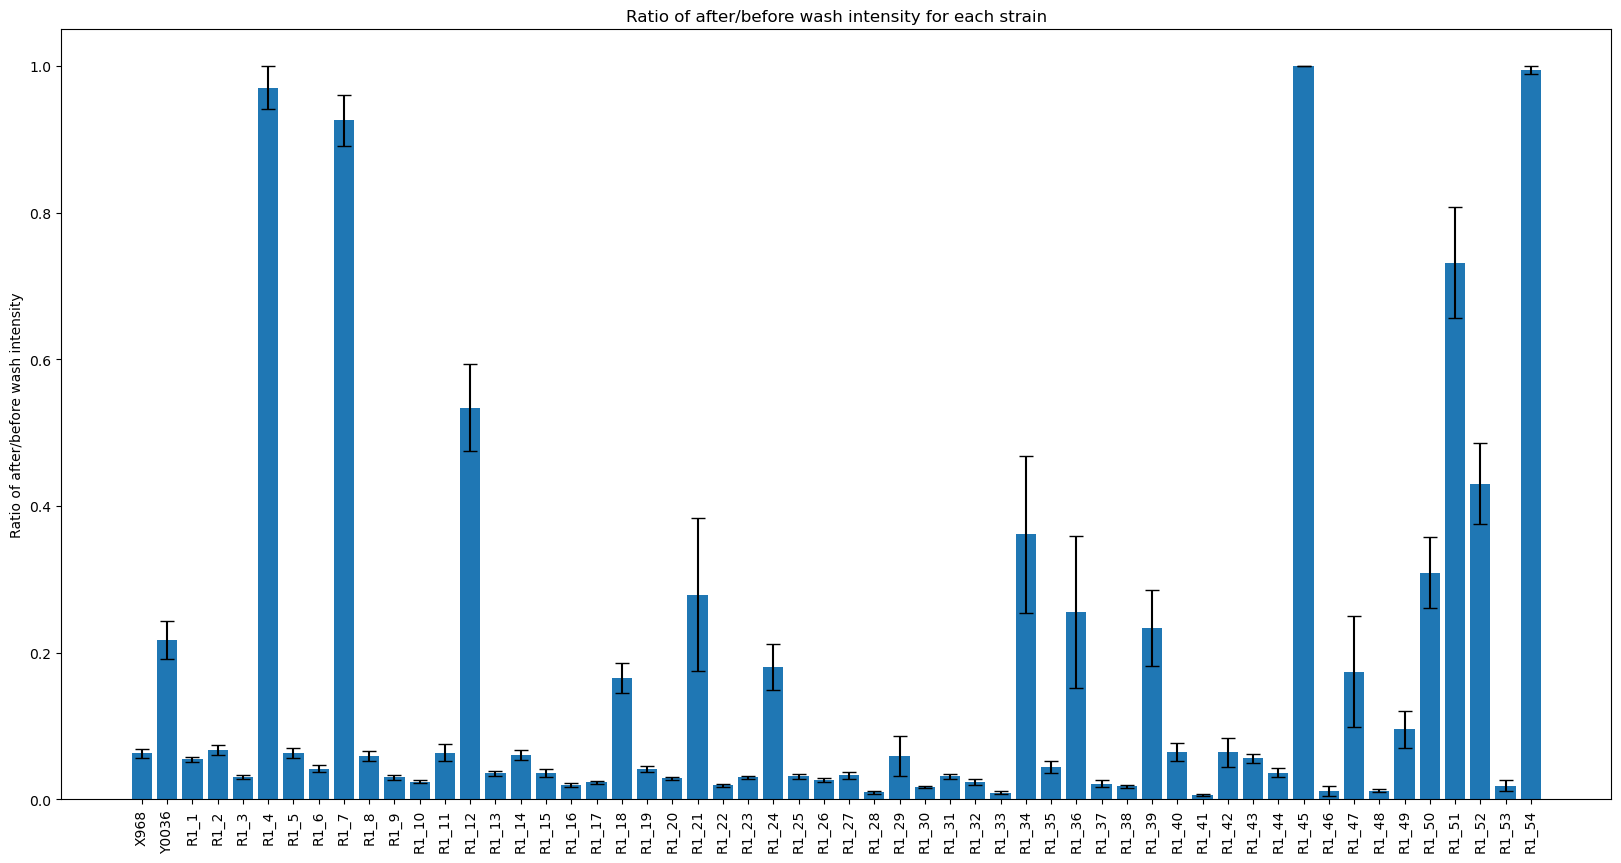

In [28]:
#create barchart with error bars
plt.figure(figsize=(20,10))
plt.bar(phenotype_s["strain"],phenotype_s["ratio"],yerr=phenotype_s["sem"],capsize=5)
plt.xticks(rotation=90)
plt.ylabel("Ratio of after/before wash intensity")
plt.title("Ratio of after/before wash intensity for each strain")
plt.show()
#to csv
phenotype_s.to_csv("phenotype_s.csv")

### Segregants on YES


In [29]:
DF_s_yes = pd.concat([df_s_yes_1,df_s_yes_2])
DF_s_yes.loc[DF_s_yes['ratio'] > 1, 'ratio'] = 1
DF_grouped_s_yes=DF_s_yes.groupby("strain",as_index=False).mean()
phenotype_s_yes=DF_grouped_s_yes[["strain","ratio","before_wash"]]
phenotype_s_yes["sem"]=DF_s_yes.groupby("strain",as_index=False).sem()["ratio"]

import re
phenotype_s_yes.reset_index(drop=True,inplace=True)
#Make all segregant names R1_x
for p in range(0,len(phenotype_s_yes["strain"])):
    if phenotype_s_yes["strain"][p][0]=="R":
        phenotype_s_yes["strain"][p]=str("R1_"+re.findall("[0-9]+",phenotype_s_yes["strain"][p])[0])

#Make parental values X968 (JB50) and Y0036 (JB759)
#find the index of JB50 and JB759
JB50_index=phenotype_s_yes[phenotype_s_yes["strain"]=="JB50"].index[0]
JB759_index=phenotype_s_yes[phenotype_s_yes["strain"]=="JB759"].index[0]
#change the names
phenotype_s_yes["strain"][JB50_index]="X968"
phenotype_s_yes["strain"][JB759_index]="Y0036"
#drop entries where strain is JB22 or JB869
phenotype_s_yes=phenotype_s_yes.drop(phenotype_s_yes[phenotype_s_yes["strain"]=="JB22"].index[0])
phenotype_s_yes=phenotype_s_yes.drop(phenotype_s_yes[phenotype_s_yes["strain"]=="JB869"].index[0])
#reorder the dataframe by strains such as X968, Y0036, R1_1 .... R1_53
#make a dummy colum with values after R1_ and sort ascending. Then put X968 and Y0036 at the top
phenotype_s_yes["dummy"]=phenotype_s_yes["strain"].str.split("R1_",expand=True)[1]
#change dtype to int with pandas
phenotype_s_yes["dummy"]=pd.to_numeric(phenotype_s_yes["dummy"])
#assign dummy value of -1 and 0 to X968 and Y0036
phenotype_s_yes.loc[phenotype_s_yes["strain"]=="X968","dummy"]=-1
phenotype_s_yes.loc[phenotype_s_yes["strain"]=="Y0036","dummy"]=0
phenotype_s_yes=phenotype_s_yes.sort_values(by="dummy",ascending=True)
phenotype_s_yes=phenotype_s_yes.drop("dummy",axis=1)
phenotype_s_yes=phenotype_s_yes.reset_index(drop=True)


/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/2544255282.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_s_yes["sem"]=DF_s_yes.groupby("strain",as_index=False).sem()["ratio"]
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/2544255282.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_s_yes["strain"][p]=str("R1_"+re.findall("[0-9]+",phenotype_s_yes["strain"][p])[0])
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_46571/2544255282.py:19: SettingWithCopyWarning: 
A value is trying to be set on 

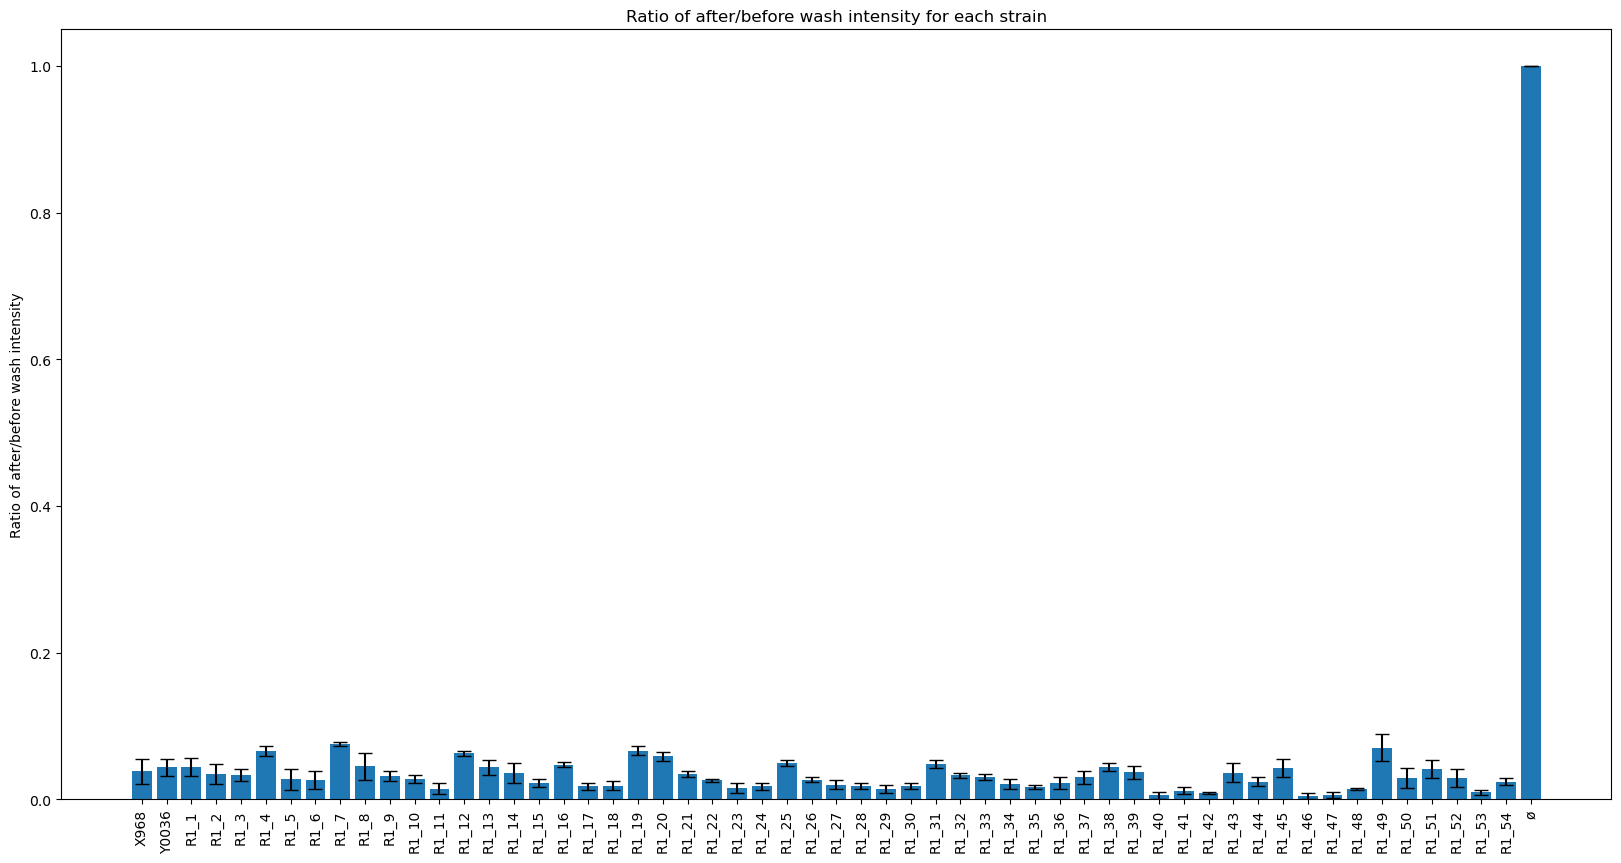

In [30]:
#create barchart with error bars
plt.figure(figsize=(20,10))
plt.bar(phenotype_s_yes["strain"],phenotype_s_yes["ratio"],yerr=phenotype_s_yes["sem"],capsize=5)
plt.xticks(rotation=90)
plt.ylabel("Ratio of after/before wash intensity")
plt.title("Ratio of after/before wash intensity for each strain")
plt.show()

In [31]:
#create a new df, where strain is the index, and ratio is the only column
phenotype_gwas=phenotype.set_index("strain")
#save to csv
phenotype_gwas.to_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/phenotype_gwas.csv')


#create barchart with error bars
plt.figure(figsize=(20,10))
plt.bar(phenotype["strain"],phenotype["ratio"],yerr=phenotype["sem"],capsize=5)
plt.xticks(rotation=90)
plt.ylabel("Ratio of after/before wash intensity")
plt.title("Ratio of after/before wash intensity for each strain")
plt.show()

OSError: Cannot save file into a non-existent directory: '/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes'

Text(0, 0.5, 'Ratio of after/before wash intensity')

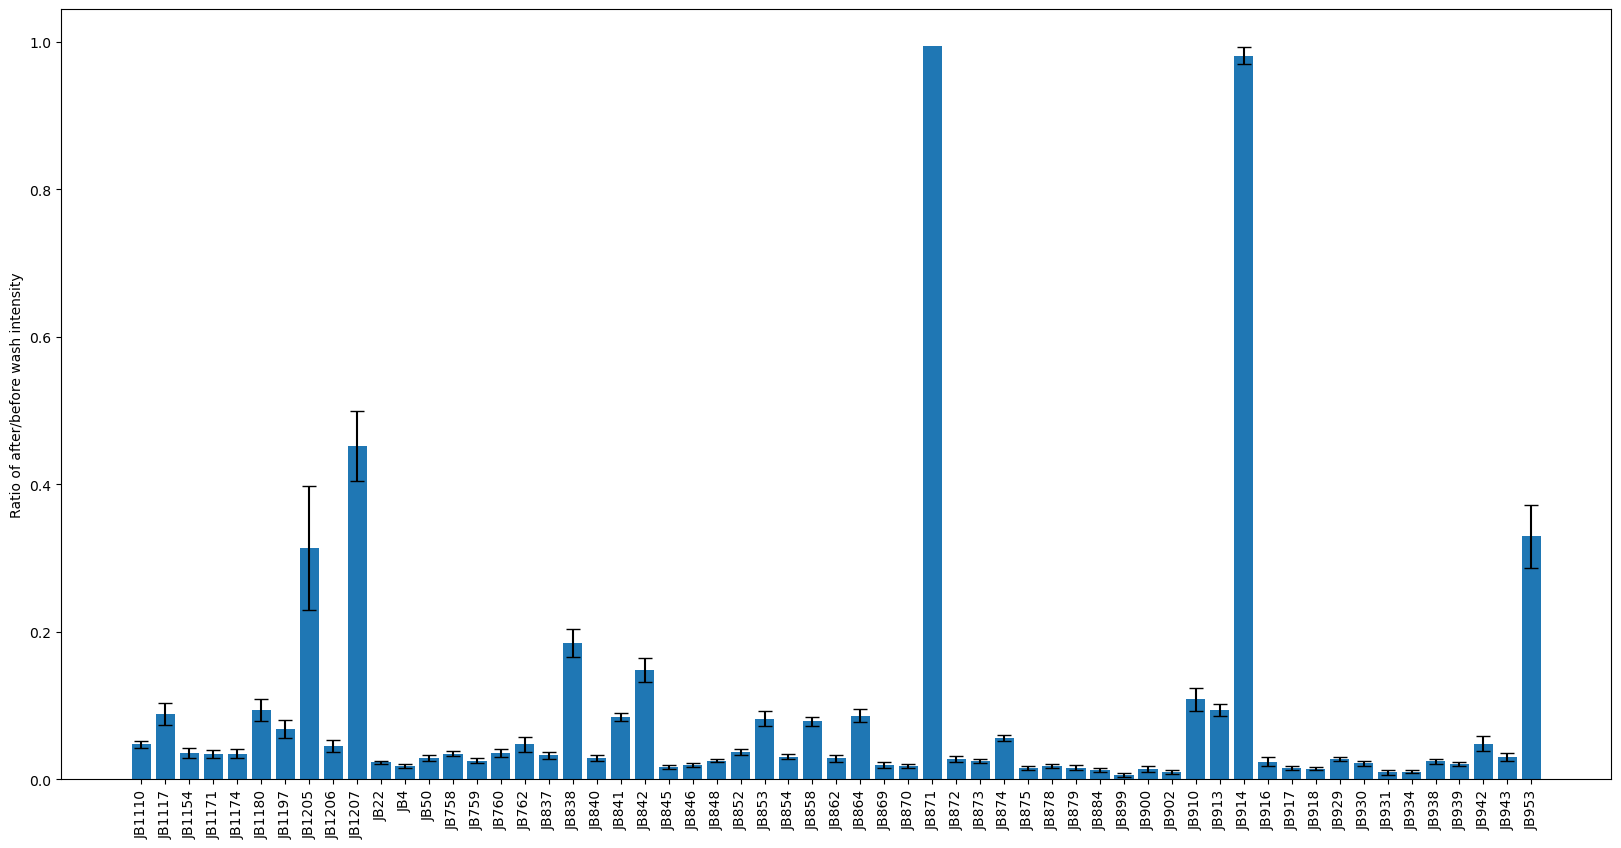

In [32]:
#same for phenotype_yes
phenotype_yes_gwas=phenotype_yes.set_index("strain")
phenotype_yes_gwas=phenotype_yes_gwas.drop(["before_wash","sem"],axis=1)
#save to csv
phenotype_yes_gwas.to_csv("phenotype_yes_gwas.csv")
#create barchart with error bars
plt.figure(figsize=(20,10))
plt.bar(phenotype_yes["strain"],phenotype_yes["ratio"],yerr=phenotype_yes["sem"],capsize=5)
plt.xticks(rotation=90)
plt.ylabel("Ratio of after/before wash intensity")

Text(0, 0.5, 'Ratio of after/before wash intensity')

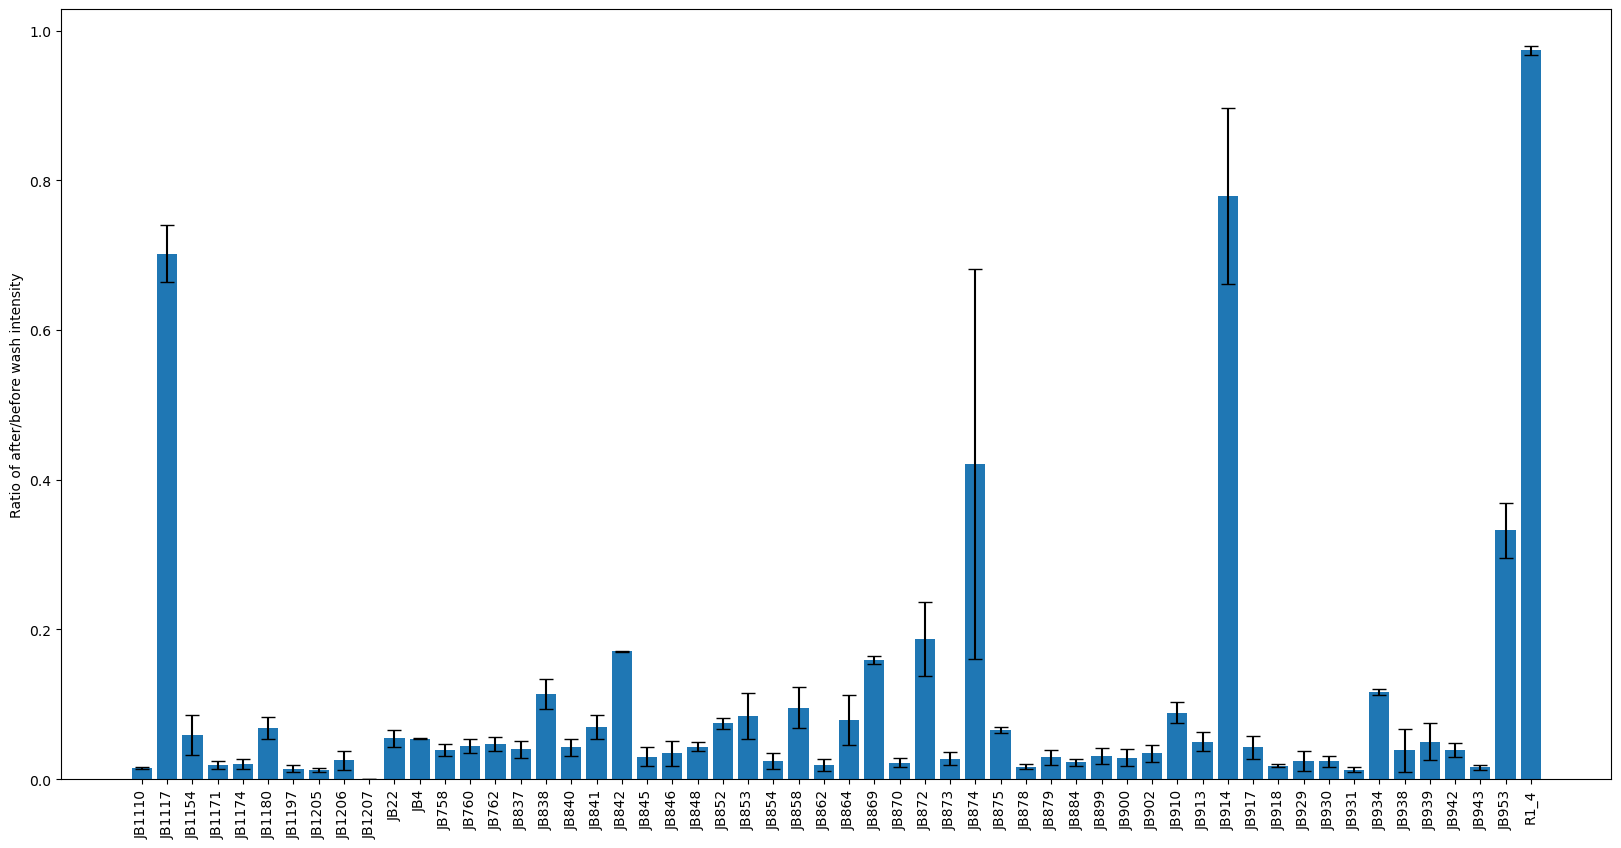

In [33]:
# same for mimi 
phenotype_mimi_gwas = phenotype_mimi.set_index("strain")
phenotype_mimi_gwas = phenotype_mimi_gwas.drop(["before_wash","sem"],axis=1)
#save to csv
phenotype_mimi_gwas.to_csv("phenotype_mimi_gwas.csv")
#create barchart with error bars
plt.figure(figsize=(20,10))
plt.bar(phenotype_mimi["strain"],phenotype_mimi["ratio"],yerr=phenotype_mimi["sem"],capsize=5)
plt.xticks(rotation=90)
plt.ylabel("Ratio of after/before wash intensity")

Text(0, 0.5, 'Ratio of after/before wash intensity')

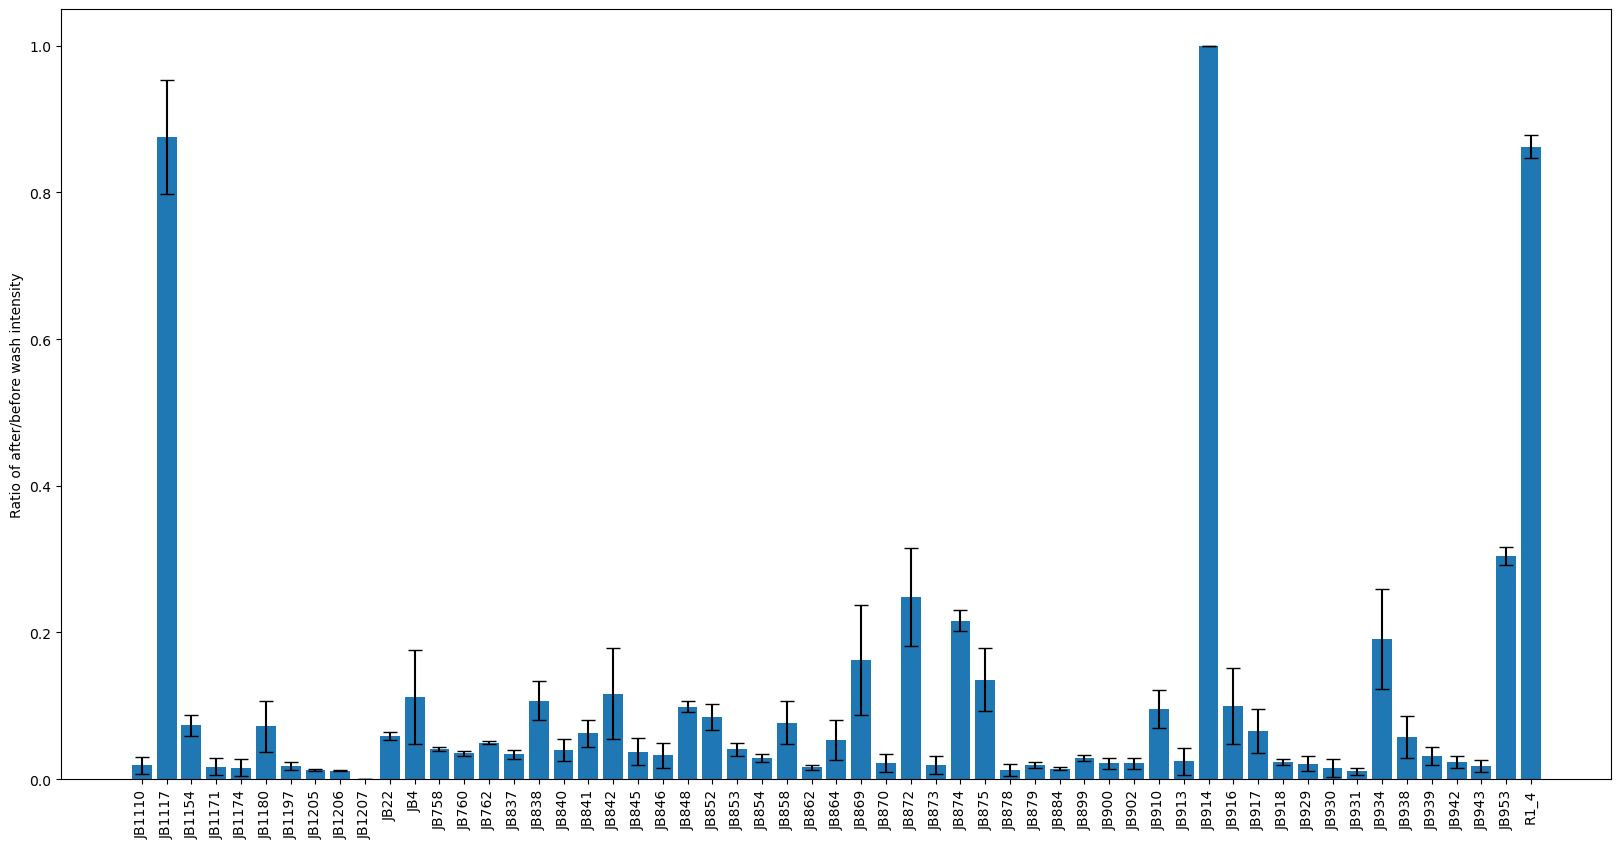

In [34]:
#repeat for cris
phenotype_cris_gwas = phenotype_cris.set_index("strain")
phenotype_cris_gwas = phenotype_cris_gwas.drop(["before_wash","sem"],axis=1)
#save to csv
phenotype_cris_gwas.to_csv("phenotype_cris_gwas.csv")
#create barchart with error bars
plt.figure(figsize=(20,10))
plt.bar(phenotype_cris["strain"],phenotype_cris["ratio"],yerr=phenotype_cris["sem"],capsize=5)
plt.xticks(rotation=90)
plt.ylabel("Ratio of after/before wash intensity")

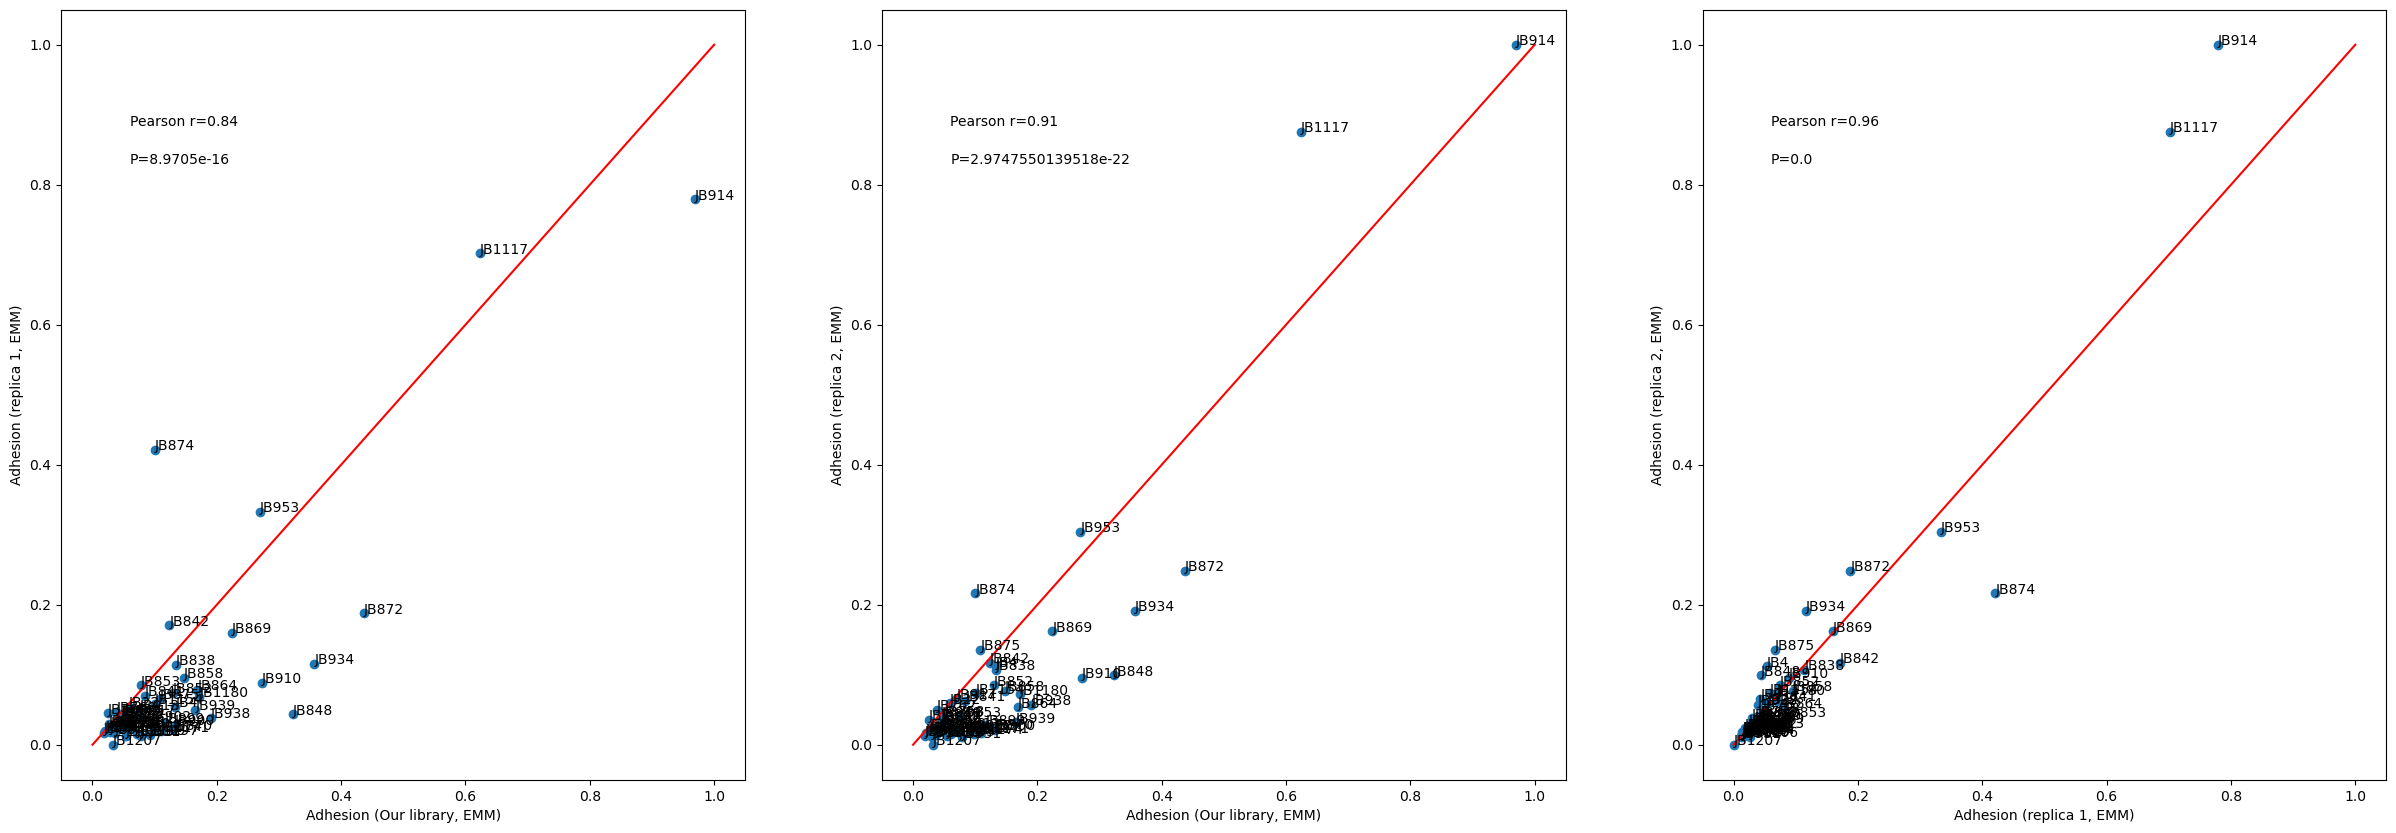

In [35]:
#merge phenotype gwas with mimi and cris and show bars grouped by strain
phenotype_gwas_merged = pd.merge(phenotype_gwas,phenotype_mimi_gwas,on="strain")
phenotype_gwas_merged = pd.merge(phenotype_gwas_merged,phenotype_cris_gwas,on="strain")
phenotype_gwas_merged = phenotype_gwas_merged.rename(columns={"ratio_x":"ratio","ratio_y":"ratio_mimi","ratio":"ratio_cris"})
phenotype_gwas_merged.to_csv("phenotype_gwas_merged.csv")
#make three separate scatter plots of the three ratios, overlay a 1:1 line
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(30,10))
ax1.scatter(phenotype_gwas_merged["ratio"],phenotype_gwas_merged["ratio_mimi"])
ax1.plot([0,1],[0,1],color="red")
ax1.set_xlabel("Adhesion (Our library, EMM)")
ax1.set_ylabel("Adhesion (replica 1, EMM)")
#print corr coef and p
ax1.text(0.1,0.85,"Pearson r="+str(round(phenotype_gwas_merged["ratio"].corr(phenotype_gwas_merged["ratio_mimi"],method="pearson"),2)),transform=ax1.transAxes)
ax1.text(0.1,0.8,"P="+str(round(stats.pearsonr(phenotype_gwas_merged["ratio"],phenotype_gwas_merged["ratio_mimi"])[1],20)),transform=ax1.transAxes)
ax2.scatter(phenotype_gwas_merged["ratio"],phenotype_gwas_merged["ratio_cris"])
ax2.plot([0,1],[0,1],color="red")
ax2.set_xlabel("Adhesion (Our library, EMM)")
ax2.set_ylabel("Adhesion (replica 2, EMM)")
#print corr coef and p
ax2.text(0.1,0.85,"Pearson r="+str(round(phenotype_gwas_merged["ratio"].corr(phenotype_gwas_merged["ratio_cris"],method="pearson"),2)),transform=ax2.transAxes)
ax2.text(0.1,0.8,"P="+str(round(stats.pearsonr(phenotype_gwas_merged["ratio"],phenotype_gwas_merged["ratio_cris"])[1],50)),transform=ax2.transAxes)

ax3.scatter(phenotype_gwas_merged["ratio_mimi"],phenotype_gwas_merged["ratio_cris"])
ax3.plot([0,1],[0,1],color="red")
ax3.set_xlabel("Adhesion (replica 1, EMM)")
ax3.set_ylabel("Adhesion (replica 2, EMM)")
#print corr coef and p
ax3.text(0.1,0.85,"Pearson r="+str(round(phenotype_gwas_merged["ratio_mimi"].corr(phenotype_gwas_merged["ratio_cris"],method="pearson"),2)),transform=ax3.transAxes)
ax3.text(0.1,0.8,"P="+str(round(stats.pearsonr(phenotype_gwas_merged["ratio_mimi"],phenotype_gwas_merged["ratio_cris"])[1],20)),transform=ax3.transAxes)
#add strain name to each dot
for i, txt in enumerate(phenotype_gwas_merged.index):
      ax1.annotate(txt, (phenotype_gwas_merged["ratio"][i], phenotype_gwas_merged["ratio_mimi"][i]))
      ax2.annotate(txt, (phenotype_gwas_merged["ratio"][i], phenotype_gwas_merged["ratio_cris"][i]))
      ax3.annotate(txt, (phenotype_gwas_merged["ratio_mimi"][i], phenotype_gwas_merged["ratio_cris"][i]))


# Plot of all the conditions



In [36]:
#concat phenotype_caf phenotype_caf_rap phenotype_caf_rap phenotype_gwas phenotype_yes phenotype_h2o2_yes phenotype_edta_yes into condition_plot_df
condition_plot_df = pd.concat([phenotype_yes,phenotype_caf,phenotype_caf_rap,phenotype_rap,phenotype_h2o2_yes,phenotype,phenotype_emm_p,phenotype_emm_n])
condition_plot_df = condition_plot_df.reset_index(drop=True)

conditions = np.array([["YES\n n=8"] * len(phenotype_yes)])[0]



conditions = np.append(conditions, [["YES Caffeine\n (10mM) \n n=7"] * len(phenotype_caf)])
conditions = np.append(conditions, [["YES Caffeine\n + Rapamycin\n n=5"] * len(phenotype_caf_rap)])
conditions = np.append(conditions, [["YES Rapamycin\n (100 ng/ml)\n n=2"] * len(phenotype_rap)])
conditions = np.append(conditions, [["YES H2O2\n n=3"] * len(phenotype_h2o2_yes)])
conditions = np.append(conditions, [["EMM\n n=11"] * len(phenotype)])
conditions = np.append(conditions, [["EMM-P\n n=4"] * len(phenotype_emm_p)])
conditions = np.append(conditions, [["EMM-N\n n=3"] * len(phenotype_emm_n)])
condition_plot_df["condition"] = conditions
#remove strain EMPTY
condition_plot_df = condition_plot_df[condition_plot_df["strain"]!="EMPTY"]
#RESET
condition_plot_df = condition_plot_df.reset_index(drop=True)
#reorder as YES, EMM, Caffeine, Caffeine + Rapamycin, Rapamycin, YES H2O2, YES EDTA
#strains above 0.3 in at least one conditoon
highest_strains = np.unique(condition_plot_df[condition_plot_df["ratio"]>0.3]["strain"])
all_strains = np.unique(condition_plot_df["strain"])



In [37]:
len(highest_strains)

20

In [38]:
#print how many strains are high
print("The fraction of cells sticking in at least one condition is "+str(len(highest_strains)/len(all_strains)))

The fraction of cells sticking in at least one condition is 0.3389830508474576


YES
 n=8 YES Caffeine
 (10mM) 
 n=7 -2.9510232276700417 0.00106
YES
 n=8 YES Caffeine
 + Rapamycin
 n=5 -2.2963747819013896 0.02047
YES
 n=8 YES Rapamycin
 (100 ng/ml)
 n=2 -0.6469785440096375 0.53682
YES
 n=8 YES H2O2
 n=3 -0.07119625834889652 0.94297
YES
 n=8 EMM
 n=11 -1.6994955806440641 0.09306
YES
 n=8 EMM-P
 n=4 -1.9212730748859699 0.05685
YES
 n=8 EMM-N
 n=3 -2.2541444051240966 0.02415


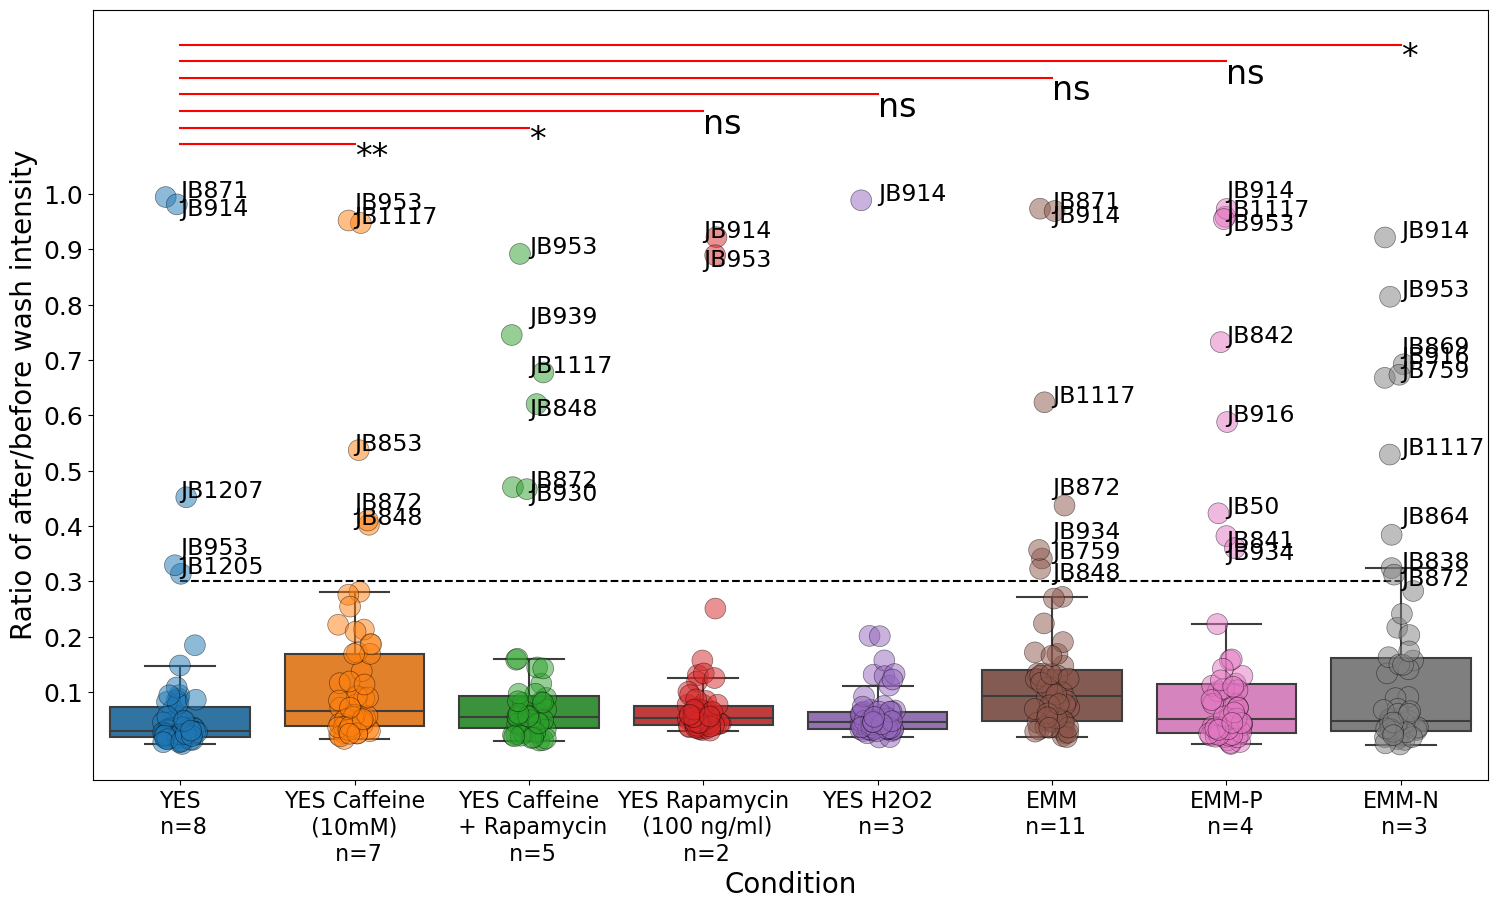

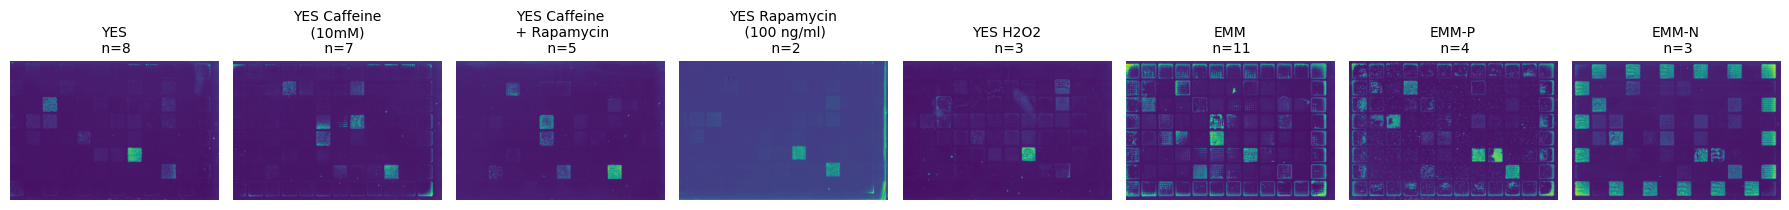

In [39]:
#Make sns boxplot and overlaid stripplot of condition_plot_df with x=condition and y=ratio
conditions=[     "YES\n n=8",
      "YES Caffeine\n (10mM) \n n=7",
      "YES Caffeine\n + Rapamycin\n n=5",
      "YES Rapamycin\n (100 ng/ml)\n n=2",
      "YES H2O2\n n=3",
      "EMM\n n=11",
      "EMM-P\n n=4",
      "EMM-N\n n=3"]

plt.figure(figsize=(18,10))
sns.boxplot(x="condition",y="ratio",data=condition_plot_df,showfliers=False)
#put black outline for circles
sns.stripplot(x="condition",y="ratio",data=condition_plot_df,jitter=True,size=15,linewidth=0.5,edgecolor="black",alpha=0.5)
plt.ylabel("Ratio of after/before wash intensity")
#draw bars between YES and all other conditions
for i in range(1,len(conditions)):
      #choose strain and ratio
      p1 = condition_plot_df[condition_plot_df["condition"]==conditions[0]][["strain","ratio"]]
      p2 = condition_plot_df[condition_plot_df["condition"]==conditions[i]][["strain","ratio"]]
      #create p3 by merging over strai
      p3 = pd.merge(p1,p2,on="strain")
      #do ttesrt with a million permutations
      s,p = stats.ttest_ind(p3["ratio_x"],p3["ratio_y"],permutations=100000)
      print(conditions[0],conditions[i],s,p)
      
      plt.plot([0,i],[i*0.03+1.06,i*0.03+1.06],color="red")
      if p<0.05:
            j=int(np.log10(p**-1))
            plt.text(i,i*0.03+1.02,j*"*",fontsize=24)
      if p>0.05:
            plt.text(i,i*0.03+1.02,"ns",fontsize=24)

#print the strain name for those with ratio>0.5
x_vals=[]
y_vals=[]

for i in range(len(condition_plot_df)):
      if condition_plot_df["ratio"][i]>0.3:
            #convert condition value to number
            condition = conditions.index(condition_plot_df["condition"][i])
            indices = [j for j, x in enumerate(x_vals) if x == condition and abs(y_vals[j]-condition_plot_df["ratio"][i])<0.1]
            y_jitter=0
            if len(indices)>0:
                  #move the larger index higher 
                  y_val_index_0 = y_vals[indices[0]]
                  if y_val_index_0>condition_plot_df["ratio"][i]:
                        y_jitter = -0.02
                  else:
                        y_jitter = 0.02


            x_vals.append(condition)
            y_vals.append(condition_plot_df["ratio"][i])
            #if there is same x val and y_val that is within 0.05, then add y_jitter, such that the text is not on top of each other
            #find index where x_vals==condition and y_vals are within 0.05 of condition_plot_df["ratio"][i]
            

            plt.text(condition,condition_plot_df["ratio"][i]+y_jitter,condition_plot_df["strain"][i],fontsize=17)
#draw a linea t 0.3
plt.plot([0,7],[0.3,0.3],color="black",linestyle="--")
#larger ticks and labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=18)
plt.xlabel("Condition",fontsize=20)
plt.ylabel("Ratio of after/before wash intensity",fontsize=20)
#onyl label y axis 0.2, 0.4, 0.6, 0.8, 1.0
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#plot isolates_caf_1_w image under each condition in asingle row, make sure centers of images are aligned with the boxplots
plt.figure(figsize=(18,5))
for i,image in zip(range(len(conditions)),[isolates_yes_1_w,isolates_caf_5_w,isolates_caf_rap_1_w,isolates_rap_2_w,isolates_yes_h2o2_3_w,isolates_4_w,
                                           isolate_emm_phosphate_1_w, isolate_emm_nitrogen_1_w]):
      image=image/np.max(image)
      image=image-np.min(image)
      plt.subplot(1,len(conditions),i+1)
      plt.imshow(image,cmap="viridis")
      plt.title(conditions[i],fontsize=10)
      plt.axis("off")
plt.tight_layout()

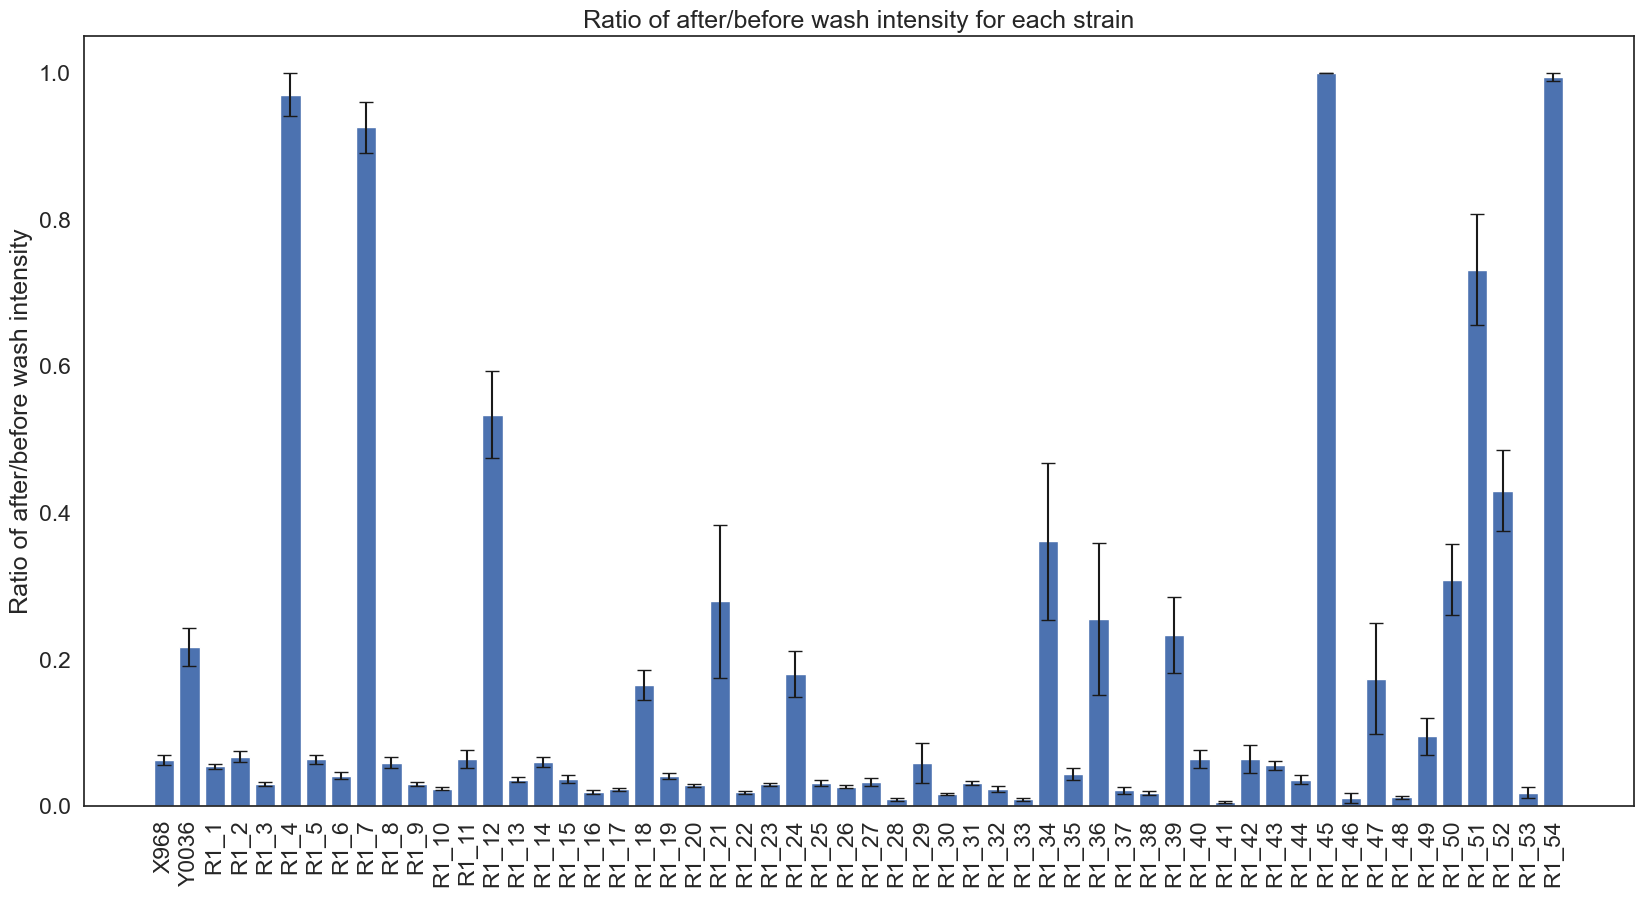

In [ ]:
#create barchart with error bars
plt.figure(figsize=(20,10))
plt.bar(phenotype_s["strain"],phenotype_s["ratio"],yerr=phenotype_s["sem"],capsize=5)
plt.xticks(rotation=90)
plt.ylabel("Ratio of after/before wash intensity")
plt.title("Ratio of after/before wash intensity for each strain")
plt.show()

In [ ]:
#save phenotype as washing_wild_isolates
phenotype_s.to_csv(root + "internal data/washing_segregants.csv",index=False)
phenotype_s.to_csv(root + "Bence folder/Phenotypes/washing_segregants.csv",index=False)

Text(0, 0.5, 'Ratio of after/before wash intensity')

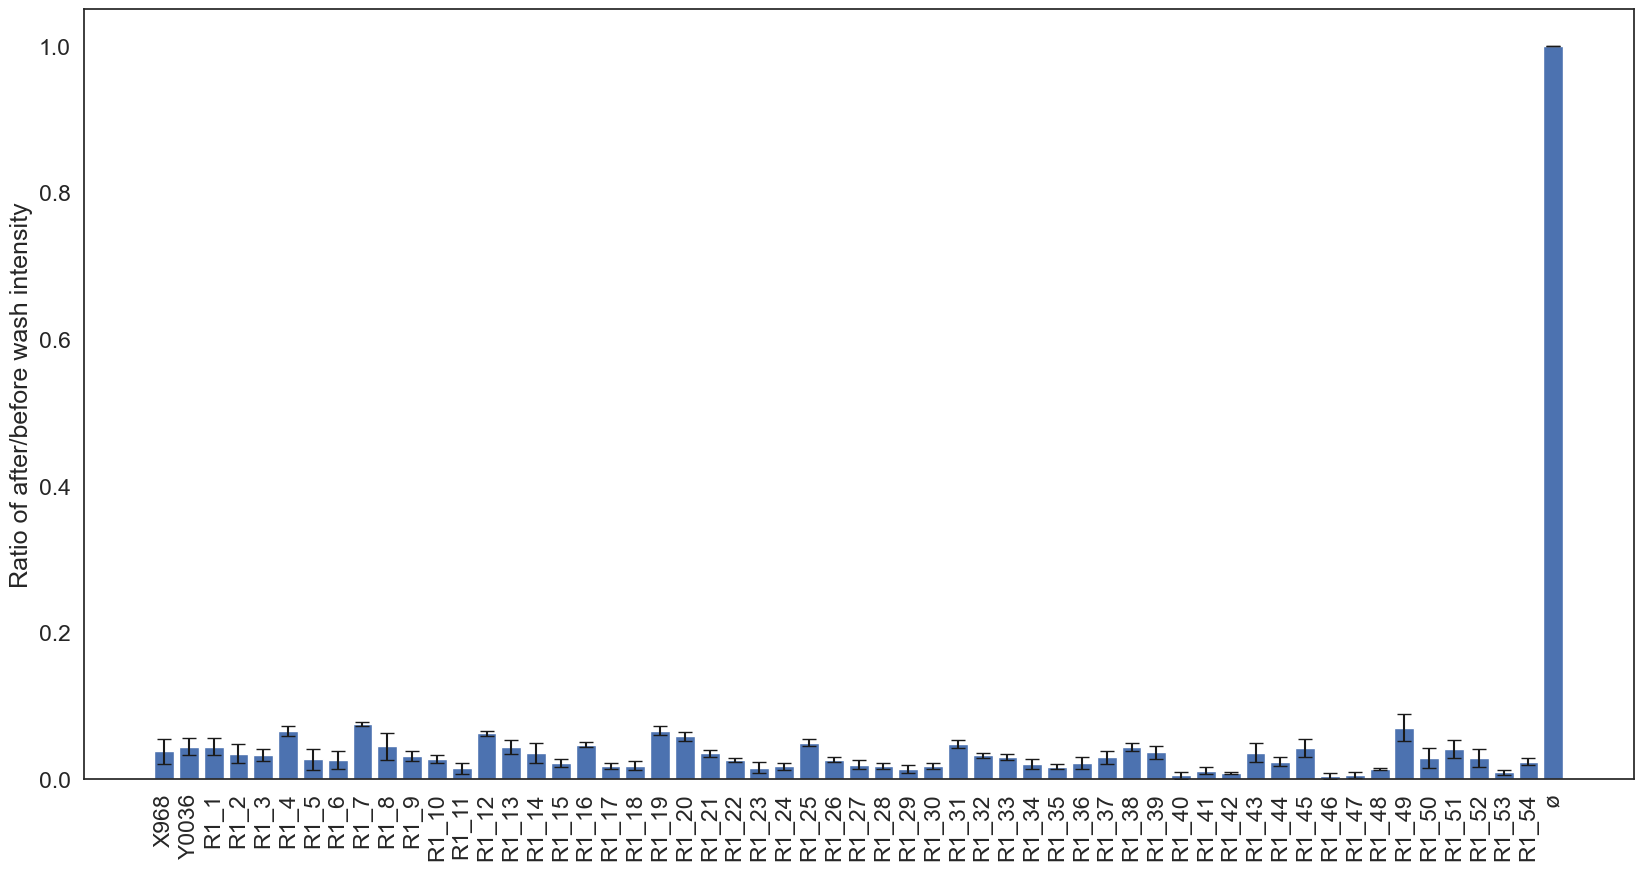

In [ ]:
#repeat for phenotype_s_yes
phenotype_s_yes_gwas=phenotype_s_yes.set_index("strain")
phenotype_s_yes_gwas=phenotype_s_yes_gwas.drop(["before_wash","sem"],axis=1)
#save to csv
phenotype_s_yes_gwas.to_csv("phenotype_s_yes_gwas.csv")
#create barchart with error bars
plt.figure(figsize=(20,10))
plt.bar(phenotype_s_yes["strain"],phenotype_s_yes["ratio"],yerr=phenotype_s_yes["sem"],capsize=5)
plt.xticks(rotation=90)
plt.ylabel("Ratio of after/before wash intensity")


In [ ]:
#import filtering data /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/filtering_results.csv delimiter is \
filtering = pd.read_csv(root + "Bence folder/Phenotypes/filtering_results.csv",delimiter="\t")
#take median of each strain across Reps but also save sem in a new column
#divide %flocc by 100
filtering["%flocc"]=filtering["%flocc"]/100
filtering_grouped=filtering.groupby("Strain",as_index=False).mean()
filtering_grouped["sem"]=filtering.groupby("Strain",as_index=False).sem()["%flocc"]
#

In [ ]:
#rename strains, such that JB759 is Y0036 and JB50 is X968, and all the ones starting with R, will start with R1_
for p in range(0,len(filtering_grouped["Strain"])):
    if filtering_grouped["Strain"][p][0]=="R":
        filtering_grouped["Strain"][p]=str("R1_"+re.findall("[0-9]+",filtering_grouped["Strain"][p])[0])
    elif filtering_grouped["Strain"][p]=="JB759":
        filtering_grouped["Strain"][p]="Y0036"
    elif filtering_grouped["Strain"][p]=="JB50":
        filtering_grouped["Strain"][p]="X968"
#merge with phenotype_s strain and Strain in filtering_grouped
filtering_phenotype=filtering_grouped.merge(phenotype_s,left_on="Strain",right_on="strain",how="inner")
filtering_phenotype.head()

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_62310/1323074989.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtering_grouped["Strain"][p]="X968"
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_62310/1323074989.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtering_grouped["Strain"][p]="Y0036"
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_62310/1323074989.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,Strain,ODf,ODr,ODf+ODr,%flocc,Rep,sem_x,strain,ratio,before_wash,sem_y
0,X968,6.600000,0.583333,7.183333,0.081319,2.00,0.004731,X968,0.062750,0.483719,0.006628
1,Y0036,4.200000,3.400000,7.600000,0.449411,1.75,0.136914,Y0036,0.217667,0.460233,0.026049
2,R1_1,6.400000,0.733333,7.133333,0.104369,2.00,0.036796,R1_1,0.054463,0.510925,0.003660
3,R1_10,6.400000,0.366667,6.766667,0.053252,2.00,0.015177,R1_10,0.024247,0.508550,0.002561
4,R1_11,7.866667,0.546667,8.413333,0.063310,2.00,0.023901,R1_11,0.063921,0.291440,0.012229


In [ ]:
filtering_phenotype["color"]=""
for i in range(0,len(filtering_phenotype["Strain"])):
    #if x968 or y0036, then color is red or yellow else blue
      if filtering_phenotype["Strain"][i]=="X968":
            filtering_phenotype["color"][i]="red"
      elif filtering_phenotype["Strain"][i]=="Y0036":
            filtering_phenotype["color"][i]="yellow"
      else:
            filtering_phenotype["color"][i]="blue"
#remove rows with X968 AND Y0036 and put to the end
x968_row=filtering_phenotype[filtering_phenotype["Strain"]=="X968"]
y0036_row=filtering_phenotype[filtering_phenotype["Strain"]=="Y0036"]
filtering_phenotype=filtering_phenotype[filtering_phenotype["Strain"]!="X968"]
filtering_phenotype=filtering_phenotype[filtering_phenotype["Strain"]!="Y0036"]
filtering_phenotype=filtering_phenotype.append(x968_row)
filtering_phenotype=filtering_phenotype.append(y0036_row)


/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_62310/196406052.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtering_phenotype["color"][i]="red"
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_62310/196406052.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtering_phenotype["color"][i]="yellow"
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_62310/196406052.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

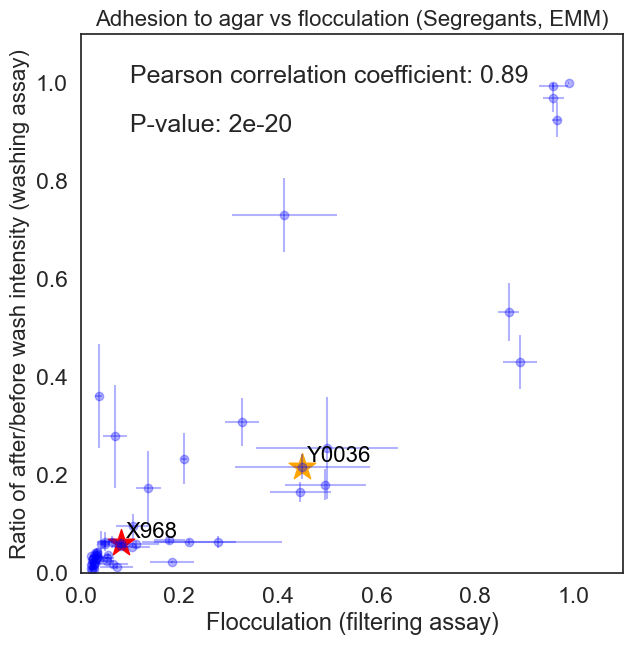

In [ ]:
#create scatterplot of filtering vs phenotype and add error bars using sem values from ffiltering_phenotype Show X968 and Y0036 in red and yellow respectively both glyph and text
plt.figure(figsize=(7,7))
#put error bars in back
plt.errorbar(filtering_phenotype["%flocc"],filtering_phenotype["ratio"],xerr=filtering_phenotype["sem_x"],yerr=filtering_phenotype["sem_y"],fmt="o",color="blue",alpha=0.3)
plt.ylabel("Ratio of after/before wash intensity (washing assay)",fontsize=16)
plt.xlabel("Flocculation (filtering assay)",fontsize=17)
plt.title("Adhesion to agar vs flocculation (Segregants, EMM)",fontsize=16)
#make it pretty
plt.xlim(0,1.1)
plt.ylim(0,1.1)
#label  X968 and Y0036 filled with red and yellow respectively both glyph and text large dot
plt.text(filtering_phenotype[filtering_phenotype["Strain"]=="X968"]["%flocc"]+0.01,filtering_phenotype[filtering_phenotype["Strain"]=="X968"]["ratio"]+0.01,"X968",color="black",fontsize=16)
plt.text(filtering_phenotype[filtering_phenotype["Strain"]=="Y0036"]["%flocc"]+0.01,filtering_phenotype[filtering_phenotype["Strain"]=="Y0036"]["ratio"]+0.01,"Y0036",color="black",fontsize=16)
#bring these in front of the error bars

plt.scatter(filtering_phenotype[filtering_phenotype["Strain"]=="X968"]["%flocc"],filtering_phenotype[filtering_phenotype["Strain"]=="X968"]["ratio"],color="red",s=400,marker="*")
plt.scatter(filtering_phenotype[filtering_phenotype["Strain"]=="Y0036"]["%flocc"],filtering_phenotype[filtering_phenotype["Strain"]=="Y0036"]["ratio"],color="orange",s=400,marker="*")




#print also a spearman correlation coefficient and p value between the two variables
plt.text(0.1,1,"Pearson correlation coefficient: "+str(round(stats.pearsonr(filtering_phenotype["%flocc"],filtering_phenotype["ratio"])[0],2)))
plt.text(0.1,0.9,"P-value: "+str(round(stats.pearsonr(filtering_phenotype["%flocc"],filtering_phenotype["ratio"])[1],20)))
plt.show()



YES EMM -3.6217392935311206 1e-06
a
a
a
a


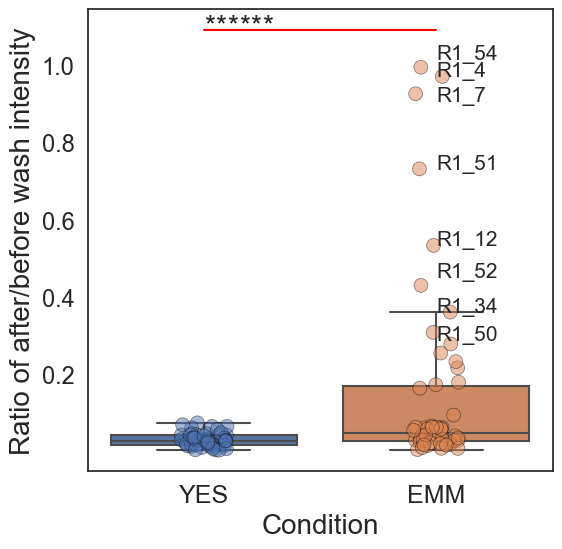

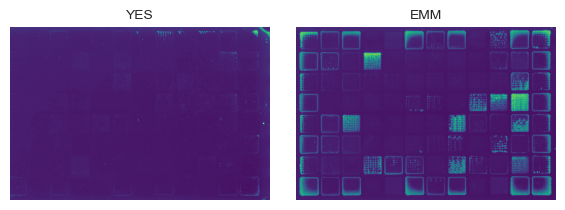

In [ ]:
#concat phenotype_caf phenotype_caf_rap phenotype_caf_rap phenotype_gwas phenotype_yes phenotype_h2o2_yes phenotype_edta_yes into condition_plot_df
phenotype_s_yes=phenotype_s_yes[phenotype_s_yes["strain"]!="ø"]
#remove R1_48 and R1_45
phenotype_s_yes=phenotype_s_yes[phenotype_s_yes["strain"]!="R1_48"]
phenotype_s_yes=phenotype_s_yes[phenotype_s_yes["strain"]!="R1_45"]
phenotype_s = phenotype_s[phenotype_s["strain"]!="ø"]
#remove R1_48 and R1_45
phenotype_s=phenotype_s[phenotype_s["strain"]!="R1_48"]
phenotype_s=phenotype_s[phenotype_s["strain"]!="R1_45"]

condition_plot_df = pd.concat([phenotype_s_yes,phenotype_s])



condition_plot_df = condition_plot_df.reset_index(drop=True)
conditions = np.array([["YES"] * len(phenotype_s_yes)])[0]

conditions = np.append(conditions, [["EMM"] * len(phenotype_s)])


condition_plot_df["condition"] = conditions
#remove strain EMPTY
condition_plot_df = condition_plot_df[condition_plot_df["strain"]!="EMPTY"]
#RESET
condition_plot_df = condition_plot_df.reset_index(drop=True)
#reorder as YES, EMM, Caffeine, Caffeine + Rapamycin, Rapamycin, YES H2O2, YES EDTA
#strains above 0.3 in at least one conditoon
highest_strains = np.unique(condition_plot_df[condition_plot_df["ratio"]>0.3]["strain"])
subset_df = condition_plot_df[condition_plot_df["strain"].isin(highest_strains)]

#Make sns boxplot and overlaid stripplot of condition_plot_df with x=condition and y=ratio
conditions=[     "YES",
     "EMM"]
plt.figure(figsize=(6,6))
sns.boxplot(x="condition",y="ratio",data=condition_plot_df,showfliers=False)
#put black outline for circles
sns.stripplot(x="condition",y="ratio",data=condition_plot_df,jitter=True,size=10,linewidth=0.5,edgecolor="black",alpha=0.5)
plt.ylabel("Ratio of after/before wash intensity")
#draw bars between YES and all other conditions
for i in range(1,len(conditions)):
      #choose strain and ratio
      p1 = condition_plot_df[condition_plot_df["condition"]==conditions[0]][["strain","ratio"]]
      p2 = condition_plot_df[condition_plot_df["condition"]==conditions[i]][["strain","ratio"]]
      #create p3 by merging over strai
      p3 = pd.merge(p1,p2,on="strain")
      p3["diff"] = p3["ratio_x"]-p3["ratio_y"]
      #do t test
      s,p = stats.ttest_ind(p3["ratio_x"],p3["ratio_y"],permutations=1000000)
      print(conditions[0],conditions[i],s,p)
      if p<0.05:
            plt.plot([0,i],[i*0.03+1.06,i*0.03+1.06],color="red")
      #write as many asterisks as significant
      for j in range(int(np.log10(p**-1))):
            plt.text(j*0.05,i*0.03+1.05,"*",fontsize=20)
      if p>0.05:
            plt.text(0,i*0.03+1.05,"ns",fontsize=20)

#print the strain name for those with ratio>0.5
x_vals=[]
y_vals=[]

for i in range(len(condition_plot_df)):
      if condition_plot_df["ratio"][i]>0.3:
            #convert condition value to number
            condition = conditions.index(condition_plot_df["condition"][i])
            indices = [j for j, x in enumerate(x_vals) if x == condition and abs(y_vals[j]-condition_plot_df["ratio"][i])<0.1]
            y_jitter=0
            if len(indices)>0:
                  #move the larger index higher
                  print("a")
                  y_val_index_0 = y_vals[indices[0]]
                  if y_val_index_0>condition_plot_df["ratio"][i]:
                        y_jitter = -0.02
                  else:
                        y_jitter = 0.02


            x_vals.append(condition)
            y_vals.append(condition_plot_df["ratio"][i])
            #if there is same x val and y_val that is within 0.05, then add y_jitter, such that the text is not on top of each other
            #find index where x_vals==condition and y_vals are within 0.05 of condition_plot_df["ratio"][i]
            

            plt.text(condition,condition_plot_df["ratio"][i]+y_jitter,condition_plot_df["strain"][i],fontsize=15)

#larger ticks and labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=17)
plt.xlabel("Condition",fontsize=20)
plt.ylabel("Ratio of after/before wash intensity",fontsize=20)
#onyl label y axis 0.2, 0.4, 0.6, 0.8, 1.0
plt.yticks([0.2,0.4,0.6,0.8,1.0])
#plot isolates_caf_1_w image under each condition in asingle row, make sure centers of images are aligned with the boxplots
plt.figure(figsize=(6,6))
for i,image in zip(range(len(conditions)),[segregants_yes_2_w,segregants_3_w,]):
      image=image/np.max(image)
      image=image-np.min(image)
      plt.subplot(1,len(conditions),i+1)
      #viridis
      plt.imshow(image,cmap="viridis")
      plt.title(conditions[i],fontsize=10)
      plt.axis("off")
plt.tight_layout()

# Final segregant plot 

In [ ]:
#plot phenotype_s and phenotype_s_yes grouped by strain and plot mean and sem
seg_plot_df = pd.concat([phenotype_s,phenotype_s_yes])
#add column media with entries EMM and YES. For first len(phenotype_s) rows EMM and for the rest YES
seg_plot_df["media"]=["EMM"]*len(phenotype_s)+["YES"]*len(phenotype_s_yes)
seg_plot_df["color"]=["blue"]*len(phenotype_s)+["red"]*len(phenotype_s_yes)

#remove row with o crossed out
seg_plot_df=seg_plot_df[seg_plot_df["strain"]!="ø"]
#make a row of value in strain after "_" if a a row starts with R. otherwise say 60
seg_plot_df["strain_num"]=seg_plot_df["strain"].apply(lambda x: int(re.findall("[0-9]+",x)[1]) if x[0]=="R" else 60)
#createa column strain_unique, with each strain name plus media
seg_plot_df["strain_unique"]=seg_plot_df["strain"]+"_"+seg_plot_df["media"]

#keep ratio, media,strain
seg_plot_df=seg_plot_df[["ratio","media","strain"]]


import iqplot 
import bokeh.io
bokeh.io.show(iqplot.strip(seg_plot_df, q="ratio", cats="media", parcoord_column="strain", q_axis="y", title="EMM vs YES for segregants"))
#paired t test
stats.ttest_rel(seg_plot_df[seg_plot_df["media"]=="EMM"]["ratio"],seg_plot_df[seg_plot_df["media"]=="YES"]["ratio"])


Ttest_relResult(statistic=3.715213729293858, pvalue=0.0004898064445934783)

YES EMM 269.0 4.5632610646789996e-05
a
a
a
a


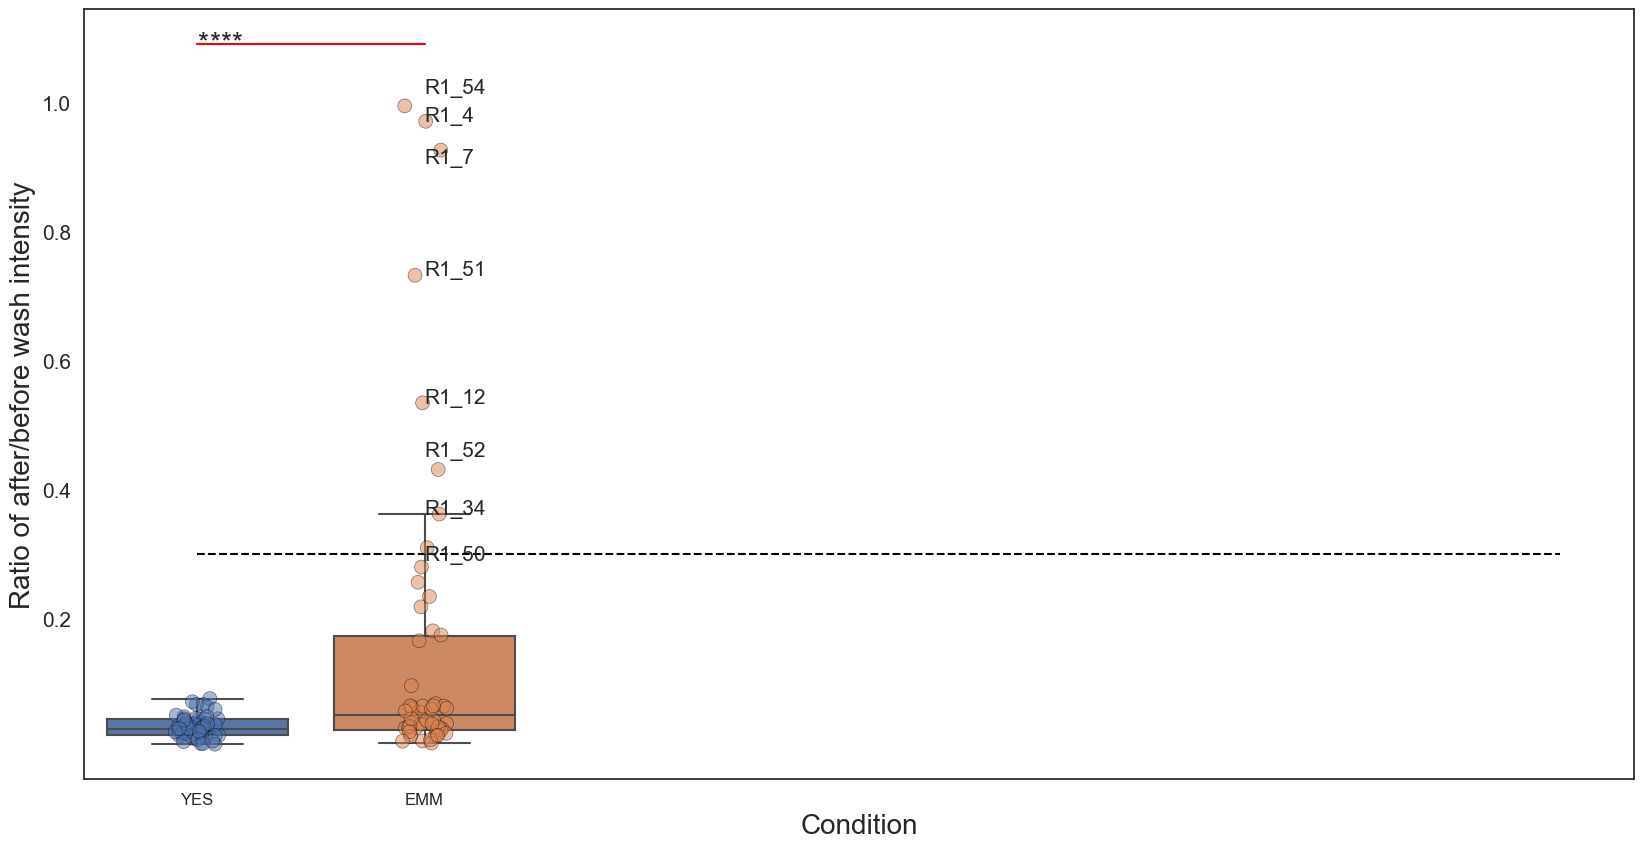

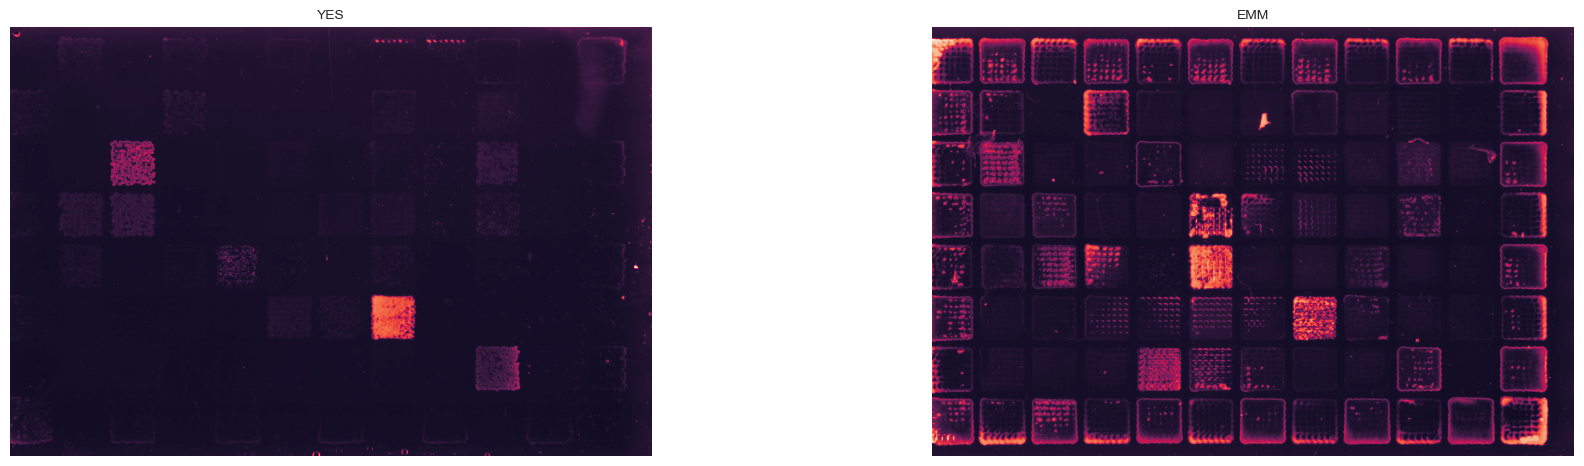

In [ ]:
#Make sns boxplot and overlaid stripplot of condition_plot_df with x=condition and y=ratio
conditions=[     "YES",
     "EMM"]
plt.figure(figsize=(20,10))
sns.boxplot(x="condition",y="ratio",data=condition_plot_df,showfliers=False)
#put black outline for circles
sns.stripplot(x="condition",y="ratio",data=condition_plot_df,jitter=True,size=10,linewidth=0.5,edgecolor="black",alpha=0.5)
plt.ylabel("Ratio of after/before wash intensity")
#draw bars between YES and all other conditions
for i in range(1,len(conditions)):
      #choose strain and ratio
      p1 = condition_plot_df[condition_plot_df["condition"]==conditions[0]][["strain","ratio"]]
      p2 = condition_plot_df[condition_plot_df["condition"]==conditions[i]][["strain","ratio"]]
      #create p3 by merging over strai
      p3 = pd.merge(p1,p2,on="strain")
      p3["diff"] = p3["ratio_x"]-p3["ratio_y"]
      #do wilcoxon test
      s,p = stats.wilcoxon(p3["diff"])
      print(conditions[0],conditions[i],s,p)
      if p<0.05:
            plt.plot([0,i],[i*0.03+1.06,i*0.03+1.06],color="red")
      #write as many asterisks as significant
      for j in range(int(np.log10(p**-1))):
            plt.text(j*0.05,i*0.03+1.05,"*",fontsize=20)
      if p>0.05:
            plt.text(0,i*0.03+1.05,"ns",fontsize=20)

#print the strain name for those with ratio>0.5
x_vals=[]
y_vals=[]

for i in range(len(condition_plot_df)):
      if condition_plot_df["ratio"][i]>0.3:
            #convert condition value to number
            condition = conditions.index(condition_plot_df["condition"][i])
            indices = [j for j, x in enumerate(x_vals) if x == condition and abs(y_vals[j]-condition_plot_df["ratio"][i])<0.1]
            y_jitter=0
            if len(indices)>0:
                  #move the larger index higher
                  print("a")
                  y_val_index_0 = y_vals[indices[0]]
                  if y_val_index_0>condition_plot_df["ratio"][i]:
                        y_jitter = -0.02
                  else:
                        y_jitter = 0.02


            x_vals.append(condition)
            y_vals.append(condition_plot_df["ratio"][i])
            #if there is same x val and y_val that is within 0.05, then add y_jitter, such that the text is not on top of each other
            #find index where x_vals==condition and y_vals are within 0.05 of condition_plot_df["ratio"][i]
            

            plt.text(condition,condition_plot_df["ratio"][i]+y_jitter,condition_plot_df["strain"][i],fontsize=15)
#draw a linea t 0.3
plt.plot([0,6],[0.3,0.3],color="black",linestyle="--")
#larger ticks and labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel("Condition",fontsize=20)
plt.ylabel("Ratio of after/before wash intensity",fontsize=20)
#onyl label y axis 0.2, 0.4, 0.6, 0.8, 1.0
plt.yticks([0.2,0.4,0.6,0.8,1.0])
#plot isolates_caf_1_w image under each condition in asingle row, make sure centers of images are aligned with the boxplots
plt.figure(figsize=(20,5))
for i,image in zip(range(len(conditions)),[isolates_yes_1_w,isolates_4_w,isolates_caf_2_w,isolates_caf_rap_1_w,isolates_rap_2_w,isolates_yes_h2o2_3_w,isolates_yes_edta_2_w]):
      image=image/np.max(image)
      image=image-np.min(image)
      plt.subplot(1,len(conditions),i+1)
      plt.imshow(image)
      plt.title(conditions[i],fontsize=10)
      plt.axis("off")
plt.tight_layout()

In [ ]:
# Plot for wild isolates adhesion vs flocculation
#read in root + "Bence folder/Phenotypes/plate_reader_wild_isolates_results.csv"
wild_isolates_floc = pd.read_csv(root + "Bence folder/Phenotypes/plate_reader_wild_isolates_results.csv",delimiter=",")

Text(0.2, 0.8, 'P-value: 0.0036')

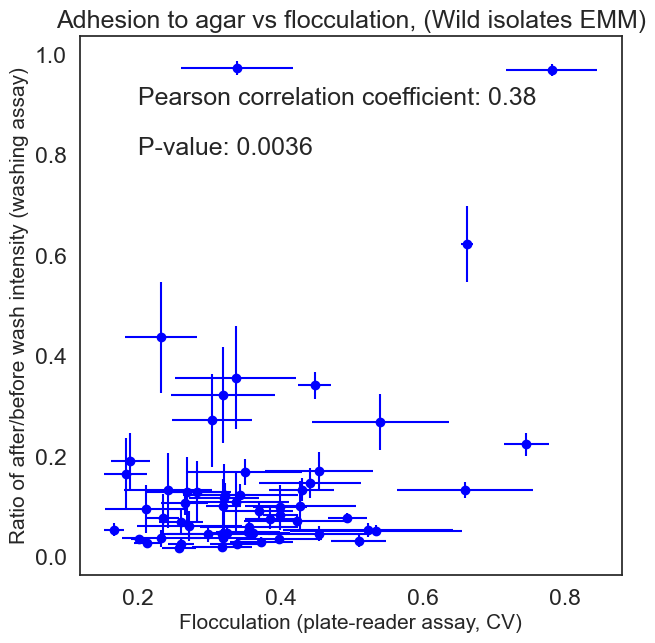

In [ ]:
#wild_isolates_floc merge with phenotype_gwas
wild_isolates_floc_phenotype=wild_isolates_floc.merge(phenotype_gwas_with_sem,left_on="Strain",right_on="strain",how="inner")
#create scatterplot of filtering vs phenotype and add error bars using sem values from ffiltering_phenotype 
plt.figure(figsize=(7,7))
plt.errorbar(wild_isolates_floc_phenotype["Mean"],wild_isolates_floc_phenotype["ratio"],xerr=wild_isolates_floc_phenotype["SEM"],yerr=wild_isolates_floc_phenotype["sem"],fmt="o", color="blue")
plt.ylabel("Ratio of after/before wash intensity (washing assay)",fontsize=15)
plt.xlabel("Flocculation (plate-reader assay, CV)",fontsize=15)
plt.title("Adhesion to agar vs flocculation, (Wild isolates EMM)")
#make it pretty

#test spearman correlation coefficient and p value between the two variables
plt.text(0.2,0.9,"Pearson correlation coefficient: "+str(round(stats.pearsonr(wild_isolates_floc_phenotype["Mean"],wild_isolates_floc_phenotype["ratio"])[0],2)))
#also print p value
plt.text(0.2,0.8,"P-value: "+str(round(stats.pearsonr(wild_isolates_floc_phenotype["Mean"],wild_isolates_floc_phenotype["ratio"])[1],4)))

In [ ]:
8# Plot of EMM vs YES for wild isolates
#phenotype_gwas merge with phenotype_yes
wi_emm_yes=phenotype_gwas.merge(phenotype_yes,left_on="strain",right_on="strain",how="inner")
#remove entry with strain EMPTY
wi_emm_yes=wi_emm_yes[wi_emm_yes["strain"]!="EMPTY"]
#put values of ratio_x and ratio_y into one shared column and create a second that is called media with entries EMM and YES
ratio=np.concatenate((wi_emm_yes["ratio_x"],wi_emm_yes["ratio_y"]))
media = ["EMM"]*len(wi_emm_yes["ratio_x"])+["YES"]*len(wi_emm_yes["ratio_y"])
strains = np.concatenate((wi_emm_yes["strain"],wi_emm_yes["strain"]))
plot_df = pd.DataFrame({"ratio":ratio,"media":media,"strain":strains})

import iqplot 
import bokeh.io
bokeh.io.show(iqplot.strip(plot_df, q="ratio", cats="media", parcoord_column="strain", q_axis="y", title="EMM vs YES for wild isolates"))



In [ ]:
#do a paired t-test between EMM and YES for wild isolates
stats.ttest_rel(wi_emm_yes["ratio_x"],wi_emm_yes["ratio_y"])

Ttest_relResult(statistic=3.365902046684071, pvalue=0.0013586276675658677)

In [ ]:
#Plotting the results when splitting at the most significant SNP
#read in snp data /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/updated_genotype_matrix_final_pos.tsv
snps = pd.read_csv(root + "internal data/updated_genotype_matrix_final_pos.tsv",delimiter="\t")

 

seg_plot_df = filtering_phenotype.copy()

In [ ]:
#in snps rename column 968 to X968
snps.rename(columns={"968":"X968"},inplace=True)
#keep only rows  2341 and 2431 in snps
snps=snps.iloc[[2341,2431]]
#reset
snps.reset_index(inplace=True,drop=True)
srb_geno = []
ncrna_geno = []


#itearte through seg_plot_df
for i in range(len(seg_plot_df)):
      strain=seg_plot_df.iloc[i]["strain"]
      #if strain is in snps colnames
      if strain in snps.columns:
            srb_geno.append(snps[strain][0])
            ncrna_geno.append(snps[strain][1])
      else:
            srb_geno.append(np.nan)
            ncrna_geno.append(np.nan)
seg_plot_df["srb_geno"]=srb_geno
seg_plot_df["ncrna_geno"]=ncrna_geno
seg_plot_df["srb_geno_jitter"]=seg_plot_df["srb_geno"]+np.random.normal(0,0.1,len(seg_plot_df))
seg_plot_df["ncrna_geno_jitter"]=seg_plot_df["ncrna_geno"]+np.random.normal(0,0.1,len(seg_plot_df))
#newly sequenced if in R1_34, R1_44, R1_48, R1_49,R1_50, R1_51, R1_52, R1_53 and R1_54
seg_plot_df["newly_sequenced"]=seg_plot_df["strain"].isin(["R1_34", "R1_44", "R1_48", "R1_49","R1_50", "R1_51", "R1_52", "R1_53", "R1_54"])
#remove R1_45 and R1_48
seg_plot_df=seg_plot_df[~seg_plot_df["strain"].isin(["R1_45","R1_48"])]
#reset index
seg_plot_df.reset_index(inplace=True,drop=True)



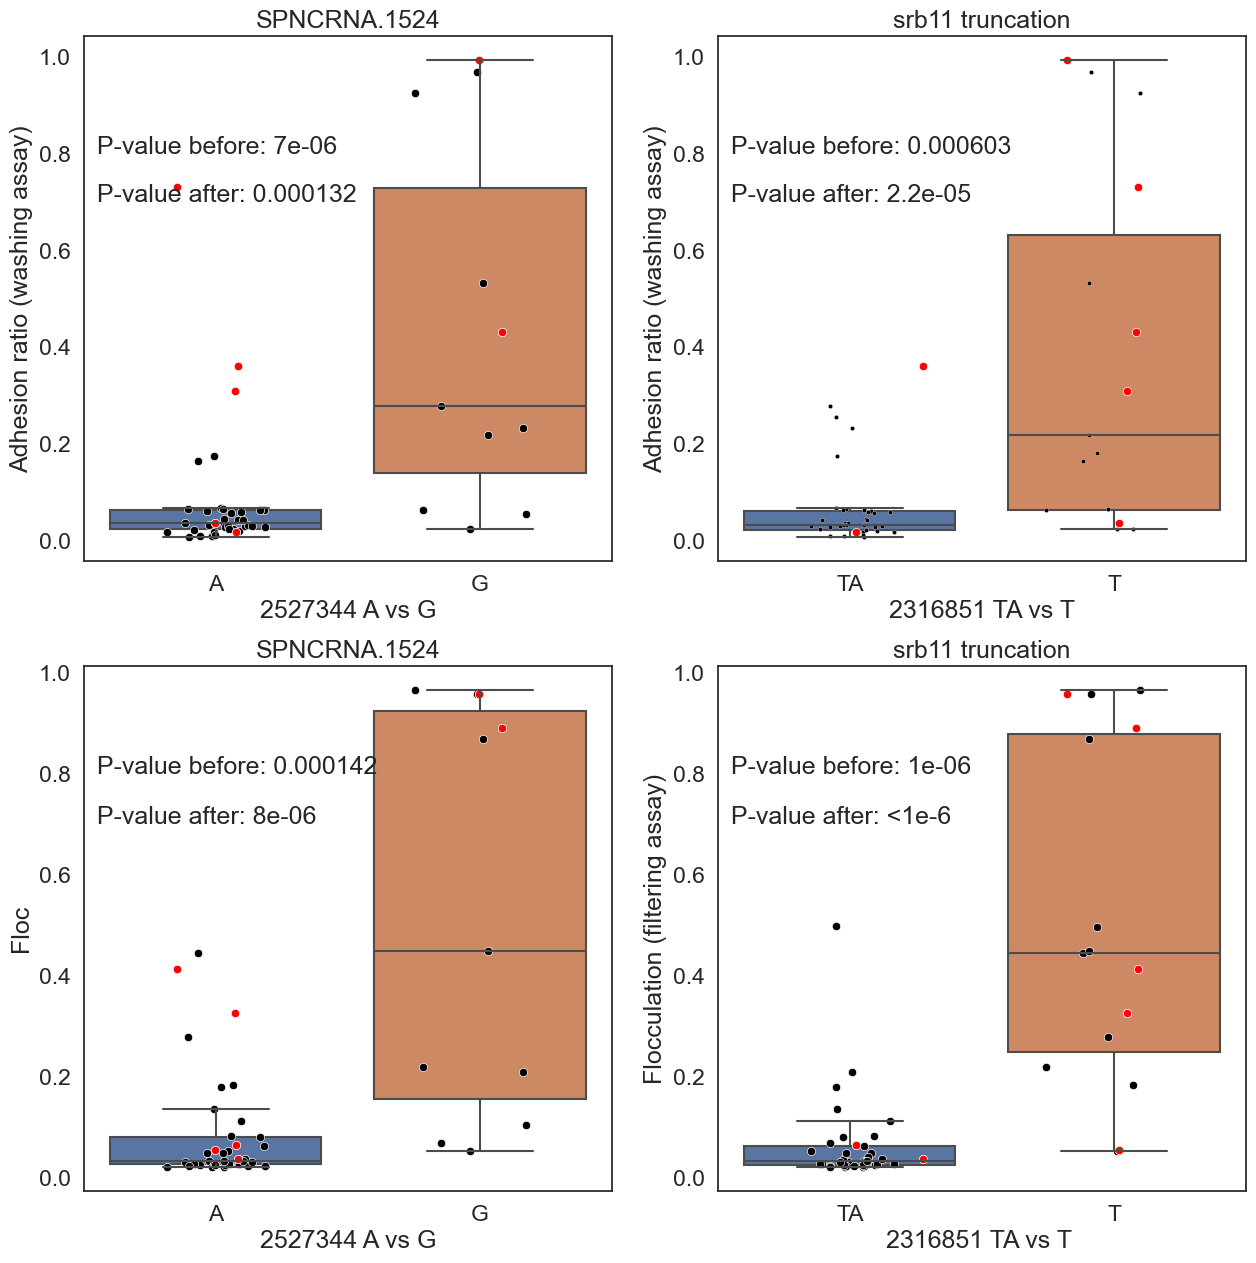

In [ ]:
#create four plots, one for each genotype vs either %flocc or ratio
fig,ax=plt.subplots(2,2,figsize=(15,15))
#iterate through the four plots
for i in range(2):
      for j in range(2):
            #if i and j are both 0
            if i==0 and j==1:
                  #plot the first plot. no outliers
                  sns.boxplot(x="srb_geno",y="ratio",data=seg_plot_df,ax=ax[i,j],showfliers=False)
                  sns.scatterplot(x="srb_geno_jitter",y="ratio",data=seg_plot_df,ax=ax[i,j],color="black", s=10)
                  #if in R1_34, R1_44, R1_48, R1_49,R1_50, R1_51, R1_52, R1_53 or R1_54
                  #scatter plot with red
                  sns.scatterplot(x="srb_geno_jitter",y="ratio",data=seg_plot_df[seg_plot_df["strain"].isin(["R1_34","R1_44","R1_48","R1_49","R1_50","R1_51","R1_52","R1_53","R1_54"])],ax=ax[i,j],color="red")

                  #set title
                  ax[i,j].set_title("srb11 truncation")
                  #set x label
                  ax[i,j].set_xlabel("2316851 TA vs T")
                  #rename x axis ticks to TA and T
                  ax[i,j].set_xticklabels(["TA","T"])
                  #set y label
                  ax[i,j].set_ylabel("Adhesion ratio (washing assay)")
                  #add P-value
                  ax[i,j].text(-0.45,0.7,"P-value after: "+str(round(stats.ttest_ind(seg_plot_df[seg_plot_df["srb_geno"]==0]["ratio"],seg_plot_df[seg_plot_df["srb_geno"]==1]["ratio"],permutations=1000000)[1],10)))
                  #add P-value before, where measurements for newly sequenced strains are removed
                  
                  ax[i,j].text(-0.45,0.8,"P-value before: "+str(round(stats.ttest_ind(seg_plot_df[(seg_plot_df["srb_geno"]==0) & (seg_plot_df["newly_sequenced"]==False)]["ratio"],seg_plot_df[(seg_plot_df["srb_geno"]==1) & (seg_plot_df["newly_sequenced"]==False)]["ratio"],permutations=1000000)[1],10)))
            #if i and j are both 1
            elif i==1 and j==1:
                  #plot the last plot
                  sns.boxplot(x="srb_geno",y="%flocc",data=seg_plot_df,ax=ax[i,j],showfliers=False)
                  sns.scatterplot(x="srb_geno_jitter",y="%flocc",data=seg_plot_df,ax=ax[i,j],color="black")
                  #if in R1_34, R1_44, R1_48, R1_49,R1_50, R1_51, R1_52, R1_53 or R1_54
                  #scatter plot with red
                  sns.scatterplot(x="srb_geno_jitter",y="%flocc",data=seg_plot_df[seg_plot_df["strain"].isin(["R1_34","R1_44","R1_48","R1_49","R1_50","R1_51","R1_52","R1_53","R1_54"])],ax=ax[i,j],color="red")
                  #set title
                  ax[i,j].set_title("srb11 truncation")
                  #set x label
                  ax[i,j].set_xlabel("2316851 TA vs T ")
                  ax[i,j].set_xticklabels(["TA","T"])
                  #set y label
                  ax[i,j].set_ylabel("Flocculation (filtering assay)")
                  #add P-value
                  #If less then permutation permits, then say P-value<1e-6
                  if stats.ttest_ind(seg_plot_df[seg_plot_df["srb_geno"]==0]["%flocc"],seg_plot_df[seg_plot_df["srb_geno"]==1]["%flocc"],permutations=1000000)[1]<1e-6:
                        ax[i,j].text(-0.45,0.7,"P-value after: <1e-6")
                  else:
                        ax[i,j].text(-0.45,0.7,"P-value after: "+str(round(stats.ttest_ind(seg_plot_df[seg_plot_df["srb_geno"]==0]["%flocc"],seg_plot_df[seg_plot_df["srb_geno"]==1]["%flocc"],permutations=1000000)[1],10)))
#                  #add P-value before, where measurements for newly sequenced strains are removed
                  ax[i,j].text(-0.45,0.8,"P-value before: "+str(round(stats.ttest_ind(seg_plot_df[(seg_plot_df["srb_geno"]==0) & (seg_plot_df["newly_sequenced"]==False)]["%flocc"],seg_plot_df[(seg_plot_df["srb_geno"]==1) & (seg_plot_df["newly_sequenced"]==False)]["%flocc"],permutations=1000000)[1],10)))
            #if i is 0 and j is 1
            elif i==0 and j==0:
                  #plot the second plot
                  sns.boxplot(x="ncrna_geno",y="ratio",data=seg_plot_df,ax=ax[i,j],showfliers=False)
                  sns.scatterplot(x="ncrna_geno_jitter",y="ratio",data=seg_plot_df,ax=ax[i,j],color="black")
                  #if in R1_34, R1_44, R1_48, R1_49,R1_50, R1_51, R1_52, R1_53 or R1_54
                  #scatter plot with red
                  sns.scatterplot(x="ncrna_geno_jitter",y="ratio",data=seg_plot_df[seg_plot_df["strain"].isin(["R1_34","R1_44","R1_48","R1_49","R1_50","R1_51","R1_52","R1_53","R1_54"])],ax=ax[i,j],color="red")
                  #set title
                  ax[i,j].set_title("SPNCRNA.1524")
                  #set x label
                  ax[i,j].set_xlabel("2527344 A vs G")
                  ax[i,j].set_xticklabels(["A","G"])
                  #set y label
                  ax[i,j].set_ylabel("Adhesion ratio (washing assay)")
                  #add P-value
                  ax[i,j].text(-0.45,0.7,"P-value after: "+str(round(stats.ttest_ind(seg_plot_df[seg_plot_df["ncrna_geno"]==0]["ratio"],seg_plot_df[seg_plot_df["ncrna_geno"]==1]["ratio"],permutations=1000000)[1],10)))
                  #add P-value before, where measurements for newly sequenced strains are removed
                  ax[i,j].text(-0.45,0.8,"P-value before: "+str(round(stats.ttest_ind(seg_plot_df[(seg_plot_df["ncrna_geno"]==0) & (seg_plot_df["newly_sequenced"]==False)]["ratio"],seg_plot_df[(seg_plot_df["ncrna_geno"]==1) & (seg_plot_df["newly_sequenced"]==False)]["ratio"],permutations=1000000)[1],10)))
            #if i is 1 and j is 0
            elif i==1 and j==0:
                  #plot the third plot
                  sns.boxplot(x="ncrna_geno",y="%flocc",data=seg_plot_df,ax=ax[i,j],showfliers=False)
                  sns.scatterplot(x="ncrna_geno_jitter",y="%flocc",data=seg_plot_df,ax=ax[i,j],color="black")
                  #if in R1_34, R1_44, R1_48, R1_49,R1_50, R1_51, R1_52, R1_53 or R1_54
                  #scatter plot with red
                  sns.scatterplot(x="ncrna_geno_jitter",y="%flocc",data=seg_plot_df[seg_plot_df["strain"].isin(["R1_34","R1_44","R1_48","R1_49","R1_50","R1_51","R1_52","R1_53","R1_54"])],ax=ax[i,j],color="red")
                  #set title
                  ax[i,j].set_title("SPNCRNA.1524")
                  ax[i,j].set_xticklabels(["A","G"])
                  #set x label
                  ax[i,j].set_xlabel("2527344 A vs G")
                  #set y label
                  ax[i,j].set_ylabel("Floc")
                  #add P-value
                  ax[i,j].text(-0.45,0.7,"P-value after: "+str(round(stats.ttest_ind(seg_plot_df[seg_plot_df["ncrna_geno"]==0]["%flocc"],seg_plot_df[seg_plot_df["ncrna_geno"]==1]["%flocc"],permutations=1000000)[1],10)))
                  #add P-value before, where measurements for newly sequenced strains are removed
                  ax[i,j].text(-0.45,0.8,"P-value before: "+str(round(stats.ttest_ind(seg_plot_df[(seg_plot_df["ncrna_geno"]==0) & (seg_plot_df["newly_sequenced"]==False)]["%flocc"],seg_plot_df[(seg_plot_df["ncrna_geno"]==1) & (seg_plot_df["newly_sequenced"]==False)]["%flocc"],permutations=1000000)[1],10)))

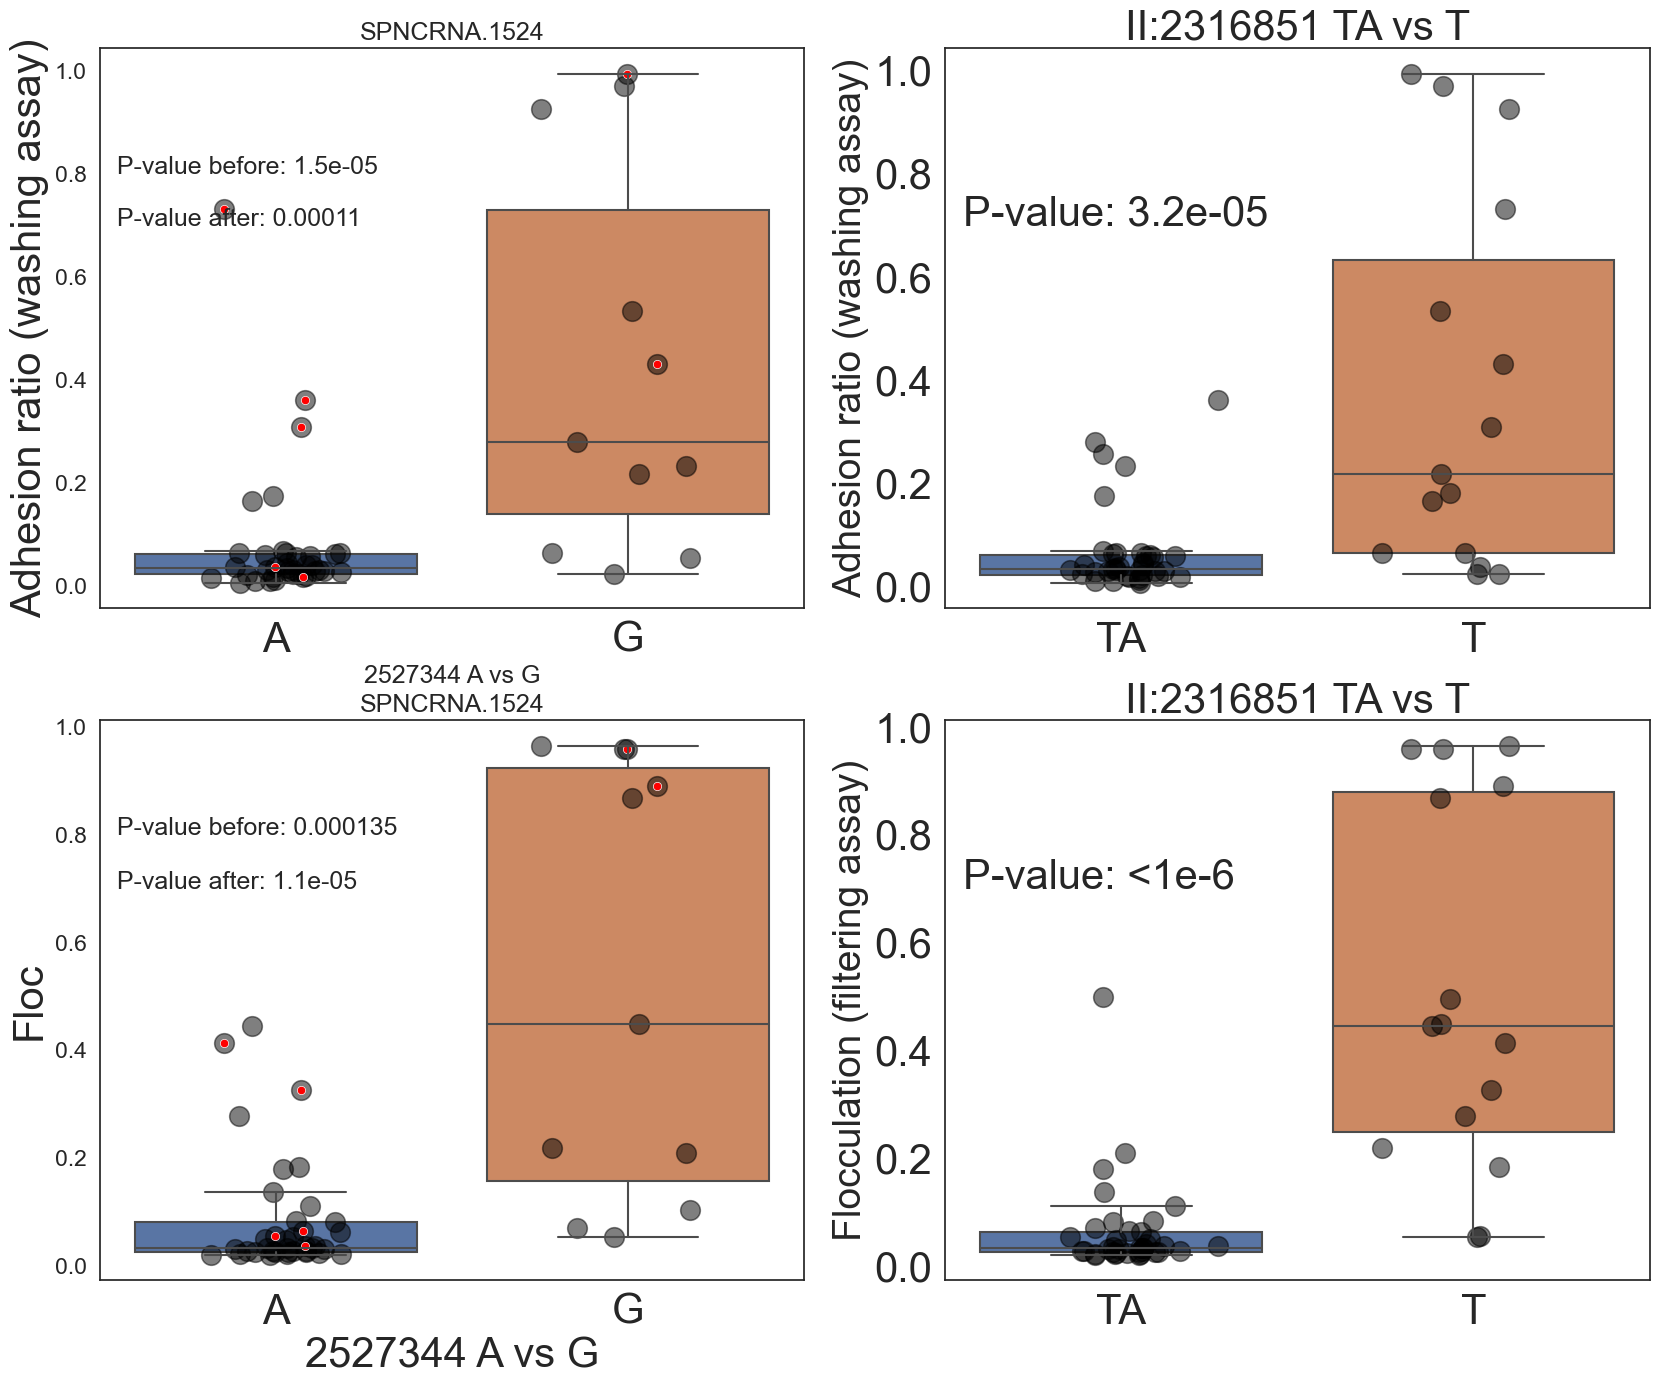

In [ ]:
#create four plots, one for each genotype vs either %flocc or ratio
fig,ax=plt.subplots(2,2,figsize=(20,16))
#iterate through the four plots
for i in range(2):
      for j in range(2):
            #if i and j are both 0
            if i==0 and j==1:
                  #plot the first plot. no outliers
                  sns.boxplot(x="srb_geno",y="ratio",data=seg_plot_df,ax=ax[i,j],showfliers=False)
                  sns.scatterplot(x="srb_geno_jitter",y="ratio",data=seg_plot_df,ax=ax[i,j],color="black", s=200,edgecolor="black",alpha=0.5)
                 
                  #set title
                  ax[i,j].set_title("II:2316851 TA vs T",fontsize=30)
                  #set x label
                  ax[i,j].set_xlabel("",fontsize=30)
                  #rename x axis ticks to TA and T
                  ax[i,j].set_xticklabels(["TA","T"],fontsize=30)
                  #set y label
                  ax[i,j].set_ylabel("Adhesion ratio (washing assay)",fontsize=28)
                  #y tick labels font size 30
                  ax[i,j].tick_params(axis='y', labelsize=30)
                  #add P-value
                  ax[i,j].text(-0.45,0.7,"P-value: "+str(round(stats.ttest_ind(seg_plot_df[seg_plot_df["srb_geno"]==0]["ratio"],seg_plot_df[seg_plot_df["srb_geno"]==1]["ratio"],permutations=1000000)[1],10)),fontsize=30)
                  #add P-value before, where measurements for newly sequenced strains are remove
            #if i and j are both 1
            elif i==1 and j==1:
                  #plot the last plot
                  sns.boxplot(x="srb_geno",y="%flocc",data=seg_plot_df,ax=ax[i,j],showfliers=False)
                  sns.scatterplot(x="srb_geno_jitter",y="%flocc",data=seg_plot_df,ax=ax[i,j],color="black", s=200,edgecolor="black",alpha=0.5)
                
                  ax[i,j].set_title("II:2316851 TA vs T",fontsize=30)
                  #set x label
                  ax[i,j].set_xlabel("",fontsize=30)
                  ax[i,j].set_xticklabels(["TA","T"],fontsize=30)
                  #set y label
                  ax[i,j].set_ylabel("Flocculation (filtering assay)",fontsize=28)
                  #y tick labels
                  ax[i,j].tick_params(axis='y', labelsize=30)
                  #add P-value
                  #If less then permutation permits, then say P-value<1e-6
                  if stats.ttest_ind(seg_plot_df[seg_plot_df["srb_geno"]==0]["%flocc"],seg_plot_df[seg_plot_df["srb_geno"]==1]["%flocc"],permutations=1000000)[1]<1e-6:
                        ax[i,j].text(-0.45,0.7,"P-value: <1e-6",fontsize=30)
                  else:
                        ax[i,j].text(-0.45,0.7,"P-value: "+str(round(stats.ttest_ind(seg_plot_df[seg_plot_df["srb_geno"]==0]["%flocc"],seg_plot_df[seg_plot_df["srb_geno"]==1]["%flocc"],permutations=1000000)[1],10)),fontsize=30)
#                  #add P-value before, where measurements for newly sequenced strains are removed
                  
            elif i==0 and j==0:
                  #plot the second plot
                  sns.boxplot(x="ncrna_geno",y="ratio",data=seg_plot_df,ax=ax[i,j],showfliers=False)
                  sns.scatterplot(x="ncrna_geno_jitter",y="ratio",data=seg_plot_df,ax=ax[i,j],color="black", s=200,edgecolor="black",alpha=0.5)
                  #if in R1_34, R1_44, R1_48, R1_49,R1_50, R1_51, R1_52, R1_53 or R1_54
                  #scatter plot with red
                  sns.scatterplot(x="ncrna_geno_jitter",y="ratio",data=seg_plot_df[seg_plot_df["strain"].isin(["R1_34","R1_44","R1_48","R1_49","R1_50","R1_51","R1_52","R1_53","R1_54"])],ax=ax[i,j],color="red")
                  #set title
                  ax[i,j].set_title("SPNCRNA.1524")
                  #set x label
                  ax[i,j].set_xlabel("2527344 A vs G")
                  ax[i,j].set_xticklabels(["A","G"],fontsize=30)
                  #set y label
                  ax[i,j].set_ylabel("Adhesion ratio (washing assay)",fontsize=30)
                  #add P-value
                  ax[i,j].text(-0.45,0.7,"P-value after: "+str(round(stats.ttest_ind(seg_plot_df[seg_plot_df["ncrna_geno"]==0]["ratio"],seg_plot_df[seg_plot_df["ncrna_geno"]==1]["ratio"],permutations=1000000)[1],10)))
                  #add P-value before, where measurements for newly sequenced strains are removed
                  ax[i,j].text(-0.45,0.8,"P-value before: "+str(round(stats.ttest_ind(seg_plot_df[(seg_plot_df["ncrna_geno"]==0) & (seg_plot_df["newly_sequenced"]==False)]["ratio"],seg_plot_df[(seg_plot_df["ncrna_geno"]==1) & (seg_plot_df["newly_sequenced"]==False)]["ratio"],permutations=1000000)[1],10)))
            #if i is 1 and j is 0
            elif i==1 and j==0:
                  #plot the third plot
                  sns.boxplot(x="ncrna_geno",y="%flocc",data=seg_plot_df,ax=ax[i,j],showfliers=False)
                  sns.scatterplot(x="ncrna_geno_jitter",y="%flocc",data=seg_plot_df,ax=ax[i,j],color="black", s=200,edgecolor="black",alpha=0.5)
                  #if in R1_34, R1_44, R1_48, R1_49,R1_50, R1_51, R1_52, R1_53 or R1_54
                  #scatter plot with red
                  sns.scatterplot(x="ncrna_geno_jitter",y="%flocc",data=seg_plot_df[seg_plot_df["strain"].isin(["R1_34","R1_44","R1_48","R1_49","R1_50","R1_51","R1_52","R1_53","R1_54"])],ax=ax[i,j],color="red")
                  #set title
                  ax[i,j].set_title("SPNCRNA.1524")
                  ax[i,j].set_xticklabels(["A","G"],fontsize=30)
                  #set x label
                  ax[i,j].set_xlabel("2527344 A vs G",fontsize=30)
                  #set y label
                  ax[i,j].set_ylabel("Floc",fontsize=30)
                  #add P-value
                  ax[i,j].text(-0.45,0.7,"P-value after: "+str(round(stats.ttest_ind(seg_plot_df[seg_plot_df["ncrna_geno"]==0]["%flocc"],seg_plot_df[seg_plot_df["ncrna_geno"]==1]["%flocc"],permutations=1000000)[1],10)))
                  #add P-value before, where measurements for newly sequenced strains are removed
                  ax[i,j].text(-0.45,0.8,"P-value before: "+str(round(stats.ttest_ind(seg_plot_df[(seg_plot_df["ncrna_geno"]==0) & (seg_plot_df["newly_sequenced"]==False)]["%flocc"],seg_plot_df[(seg_plot_df["ncrna_geno"]==1) & (seg_plot_df["newly_sequenced"]==False)]["%flocc"],permutations=1000000)[1],10)))

In [ ]:
%load_ext watermark
%watermark -v -p numpy,pandas,scipy,bokeh,iqplot,bebi103,jupyterlab

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.31.1

numpy     : 1.21.6
pandas    : 1.4.4
scipy     : 1.7.3
bokeh     : 1.4.0
iqplot    : 0.3.0
bebi103   : not installed
jupyterlab: 3.5.3

